# Predicting Loan Payback 101
> ### `Playground Series S5E11`


## Table of Contents 
1. [Introduction & Setup](#introduction)
2. [Data Loading & Overview](#data-loading)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Feature Engineering](#feature-engineering)
5. [Complete Feature Engineering](#feature-engineering)
6. [Model Training](#model-training)
   - 6.1 `LightGBM`
   - 6.2 `XGBoost`
   - 6.3 `CatBoost`
7. [Model Evaluation](#evaluation)
8. [Ensemble Methods](#ensemble)
9. [Submission Generation](#submission)
10. [Conclusion](#conclusion)

### `Competition Goal`

Predict the **probability** that a borrower will pay back their loan based on:
- Financial metrics (income, debt, credit score)
- Loan characteristics (amount, interest rate, purpose)
- Personal information (gender, marital status, education, employment)

**Evaluation:** Area Under the ROC Curve (AUC-ROC)

<a id='introduction'></a>
> # 1️ Introduction & Setup

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.stats import rankdata

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [2]:
# Configuration
class Config:
    """Configuration class for hyperparameters and settings"""
    N_SPLITS = 5
    SEED = 42
    TARGET = 'loan_paid_back'
    VERBOSE = True
    
    # Model weights for ensemble (will be optimized later)
    WEIGHTS = {
        'lgb': 0.33,
        'xgb': 0.33,
        'cat': 0.34
    }

config = Config()
print("Configuration loaded successfully!")
print(f"- Number of folds: {config.N_SPLITS}")
print(f"- Random seed: {config.SEED}")
print(f"- Target variable: {config.TARGET}")

Configuration loaded successfully!
- Number of folds: 5
- Random seed: 42
- Target variable: loan_paid_back


<a id='data-loading'></a>
> # 2️ Data Loading & Overview

In [3]:
# Load datasets
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"\n Total rows: {train.shape[0]:,}")
print(f"Total features: {train.shape[1] - 2} (excluding id and target)")
print(f"Test samples to predict: {test.shape[0]:,}")

Train shape: (593994, 13)
Test shape: (254569, 12)
Sample submission shape: (254569, 2)

 Total rows: 593,994
Total features: 11 (excluding id and target)
Test samples to predict: 254,569


In [4]:
# First look at the data
print("TRAIN DATA PREVIEW")
display(train.head(10))

print("TEST DATA PREVIEW")
display(test.head(10))

TRAIN DATA PREVIEW


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0
5,5,44940.30,0.058,653,12159.92,12.24,Male,Single,Bachelor's,Employed,Other,D1,1.0
6,6,61574.16,0.042,696,16907.71,13.52,Other,Single,High School,Self-employed,Debt consolidation,C5,1.0
7,7,45953.31,0.100,654,10111.62,12.82,Female,Married,High School,Employed,Home,D1,1.0
8,8,30592.29,0.132,713,7522.36,9.48,Male,Married,Bachelor's,Employed,Education,C5,1.0
9,9,17342.45,0.121,548,9653.48,16.04,Female,Married,Bachelor's,Self-employed,Vacation,F1,1.0


TEST DATA PREVIEW


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1
5,593999,45302.90,0.060,675,8106.78,13.74,Female,Married,High School,Employed,Vacation,C3
6,594000,27676.47,0.061,714,8242.26,13.87,Female,Single,High School,Employed,Debt consolidation,C4
7,594001,38216.91,0.095,719,3765.50,15.10,Male,Single,High School,Employed,Other,C5
8,594002,25650.59,0.101,664,20310.64,11.74,Male,Single,High School,Employed,Education,D4
9,594003,62497.03,0.207,651,5177.58,13.90,Female,Divorced,High School,Unemployed,Car,D2


In [5]:
# Data types and memory usage
print("DATA INFO - TRAIN")
train.info()

print("DATA INFO - TEST")
test.info()

DATA INFO - TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB
DATA INFO - TEST
<class 'pan

In [6]:
# Check for missing values
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

missing_df = pd.DataFrame({
    'Feature': train.columns,
    'Train Missing': missing_train.values,
    'Train Missing %': (missing_train.values / len(train) * 100).round(2),
    'Test Missing': [missing_test.get(col, 0) for col in train.columns],
    'Test Missing %': [(missing_test.get(col, 0) / len(test) * 100) for col in train.columns]
})

missing_summary = missing_df[(missing_df['Train Missing'] > 0) | (missing_df['Test Missing'] > 0)]

if len(missing_summary) > 0:
    display(missing_summary.style.background_gradient(cmap='Reds'))
else:
    print(" No missing values found in train or test data!")
    print(" Data quality is excellent - ready for modeling!")

 No missing values found in train or test data!
 Data quality is excellent - ready for modeling!


In [7]:
# Check for duplicates
train_duplicates = train.duplicated().sum()
test_duplicates = test.duplicated().sum()

print(f"Train duplicates: {train_duplicates}")
print(f"Test duplicates: {test_duplicates}")

if train_duplicates == 0 and test_duplicates == 0:
    print(" No duplicates found!")

Train duplicates: 0
Test duplicates: 0
 No duplicates found!


In [8]:
# Target distribution
print("TARGET DISTRIBUTION ANALYSIS")

target_counts = train[config.TARGET].value_counts()
target_pct = train[config.TARGET].value_counts(normalize=True) * 100

target_summary = pd.DataFrame({
    'Value': target_counts.index,
    'Count': target_counts.values,
    'Percentage': target_pct.values
})

display(target_summary.style.background_gradient(cmap='Blues'))

print(f"\nTarget Statistics:")
print(f"- Mean: {train[config.TARGET].mean():.4f}")
print(f"- Median: {train[config.TARGET].median():.4f}")
print(f"- Std: {train[config.TARGET].std():.4f}")

# Check for class imbalance
imbalance_ratio = target_counts.min() / target_counts.max()
print(f"\n  Class Balance Ratio: {imbalance_ratio:.3f}")
if imbalance_ratio < 0.5:
    print("Dataset is imbalanced - consider using stratified sampling")
else:
    print("Dataset is relatively balanced")

TARGET DISTRIBUTION ANALYSIS


,Value,Count,Percentage
0,1.000000,474494,79.881952
1,0.000000,119500,20.118048



Target Statistics:
- Mean: 0.7988
- Median: 1.0000
- Std: 0.4009

  Class Balance Ratio: 0.252
Dataset is imbalanced - consider using stratified sampling


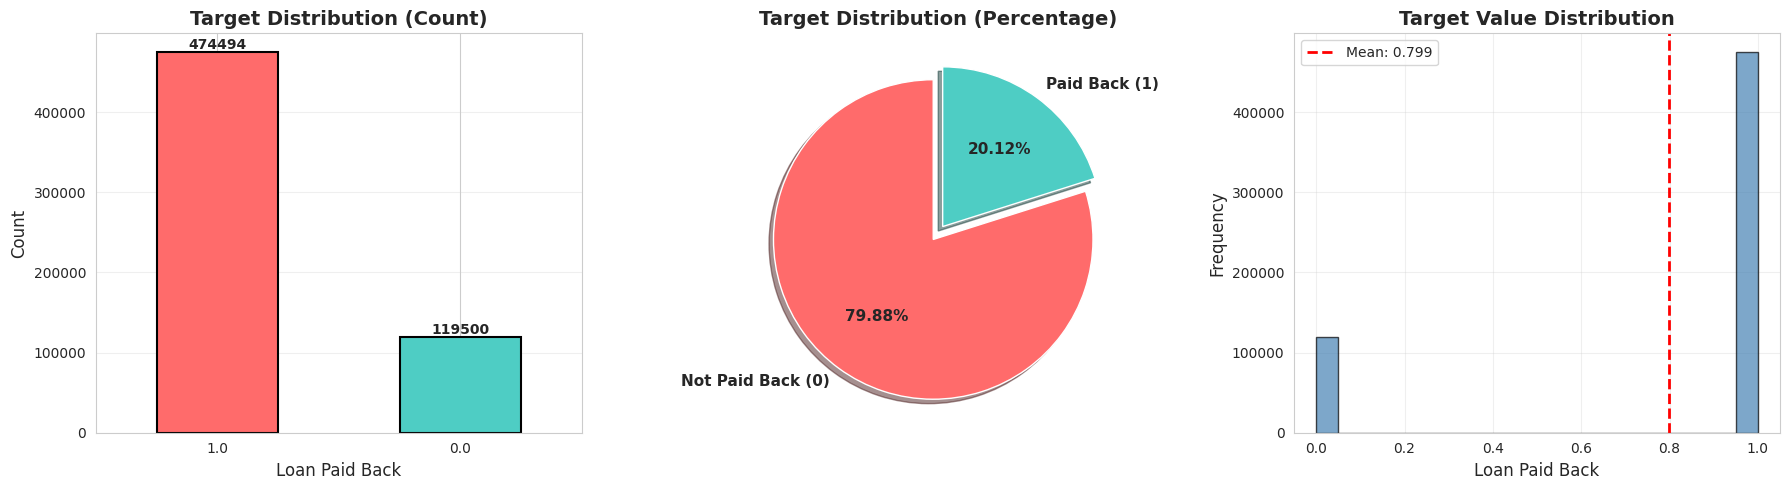

In [9]:
# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Count plot
colors = ['#FF6B6B', '#4ECDC4']
train[config.TARGET].value_counts().plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Target Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Paid Back', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(rotation=0)
axes[0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', fontsize=10, fontweight='bold')

# Pie chart
explode = (0.05, 0.05)
axes[1].pie(train[config.TARGET].value_counts(), 
            labels=['Not Paid Back (0)', 'Paid Back (1)'], 
            autopct='%1.2f%%', 
            colors=colors, 
            explode=explode, 
            shadow=True, 
            startangle=90,
            textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Target Distribution (Percentage)', fontsize=14, fontweight='bold')

# Distribution plot
axes[2].hist(train[config.TARGET], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[2].axvline(train[config.TARGET].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {train[config.TARGET].mean():.3f}")
axes[2].set_title('Target Value Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Loan Paid Back', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].legend(fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

<a id='eda'></a>
> # 3️ Exploratory Data Analysis (EDA)

## 3.1 Feature Type Identification

In [10]:
# Separate numerical and categorical columns
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('id')
if config.TARGET in numerical_cols:
    numerical_cols.remove(config.TARGET)

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

print("FEATURE TYPE SUMMARY")
print(f"\n Numerical features ({len(numerical_cols)}):")
for i, col in enumerate(numerical_cols, 1):
    print(f"{i}. {col}")

print(f"\n Categorical features ({len(categorical_cols)}):")
for i, col in enumerate(categorical_cols, 1):
    print(f"{i}. {col}")

print(f"\n Total predictive features: {len(numerical_cols) + len(categorical_cols)}")

FEATURE TYPE SUMMARY

 Numerical features (5):
1. annual_income
2. debt_to_income_ratio
3. credit_score
4. loan_amount
5. interest_rate

 Categorical features (6):
1. gender
2. marital_status
3. education_level
4. employment_status
5. loan_purpose
6. grade_subgrade

 Total predictive features: 11


## 3.2 Numerical Features Analysis

In [11]:
# Statistical summary of numerical features
print("NUMERICAL FEATURES - STATISTICAL SUMMARY")

numerical_stats = train[numerical_cols].describe().T
numerical_stats['missing'] = train[numerical_cols].isnull().sum().values
numerical_stats['skewness'] = train[numerical_cols].skew().values
numerical_stats['kurtosis'] = train[numerical_cols].kurtosis().values

display(numerical_stats.style.background_gradient(cmap='coolwarm', subset=['mean', 'std', 'skewness', 'kurtosis']))

NUMERICAL FEATURES - STATISTICAL SUMMARY


,count,mean,std,min,25%,50%,75%,max,missing,skewness,kurtosis
annual_income,593994.000000,48212.202976,26711.942078,6002.430000,27934.400000,46557.680000,60981.320000,393381.740000,0,1.719509,7.091413
debt_to_income_ratio,593994.000000,0.120696,0.068573,0.011000,0.072000,0.096000,0.156000,0.627000,0,1.406680,2.335230
credit_score,593994.000000,680.916009,55.424956,395.000000,646.000000,682.000000,719.000000,849.000000,0,-0.166993,0.095962
loan_amount,593994.000000,15020.297629,6926.530568,500.090000,10279.620000,15000.220000,18858.580000,48959.950000,0,0.207360,-0.150142
interest_rate,593994.000000,12.356345,2.008959,3.200000,10.990000,12.370000,13.680000,20.990000,0,0.049945,0.059798


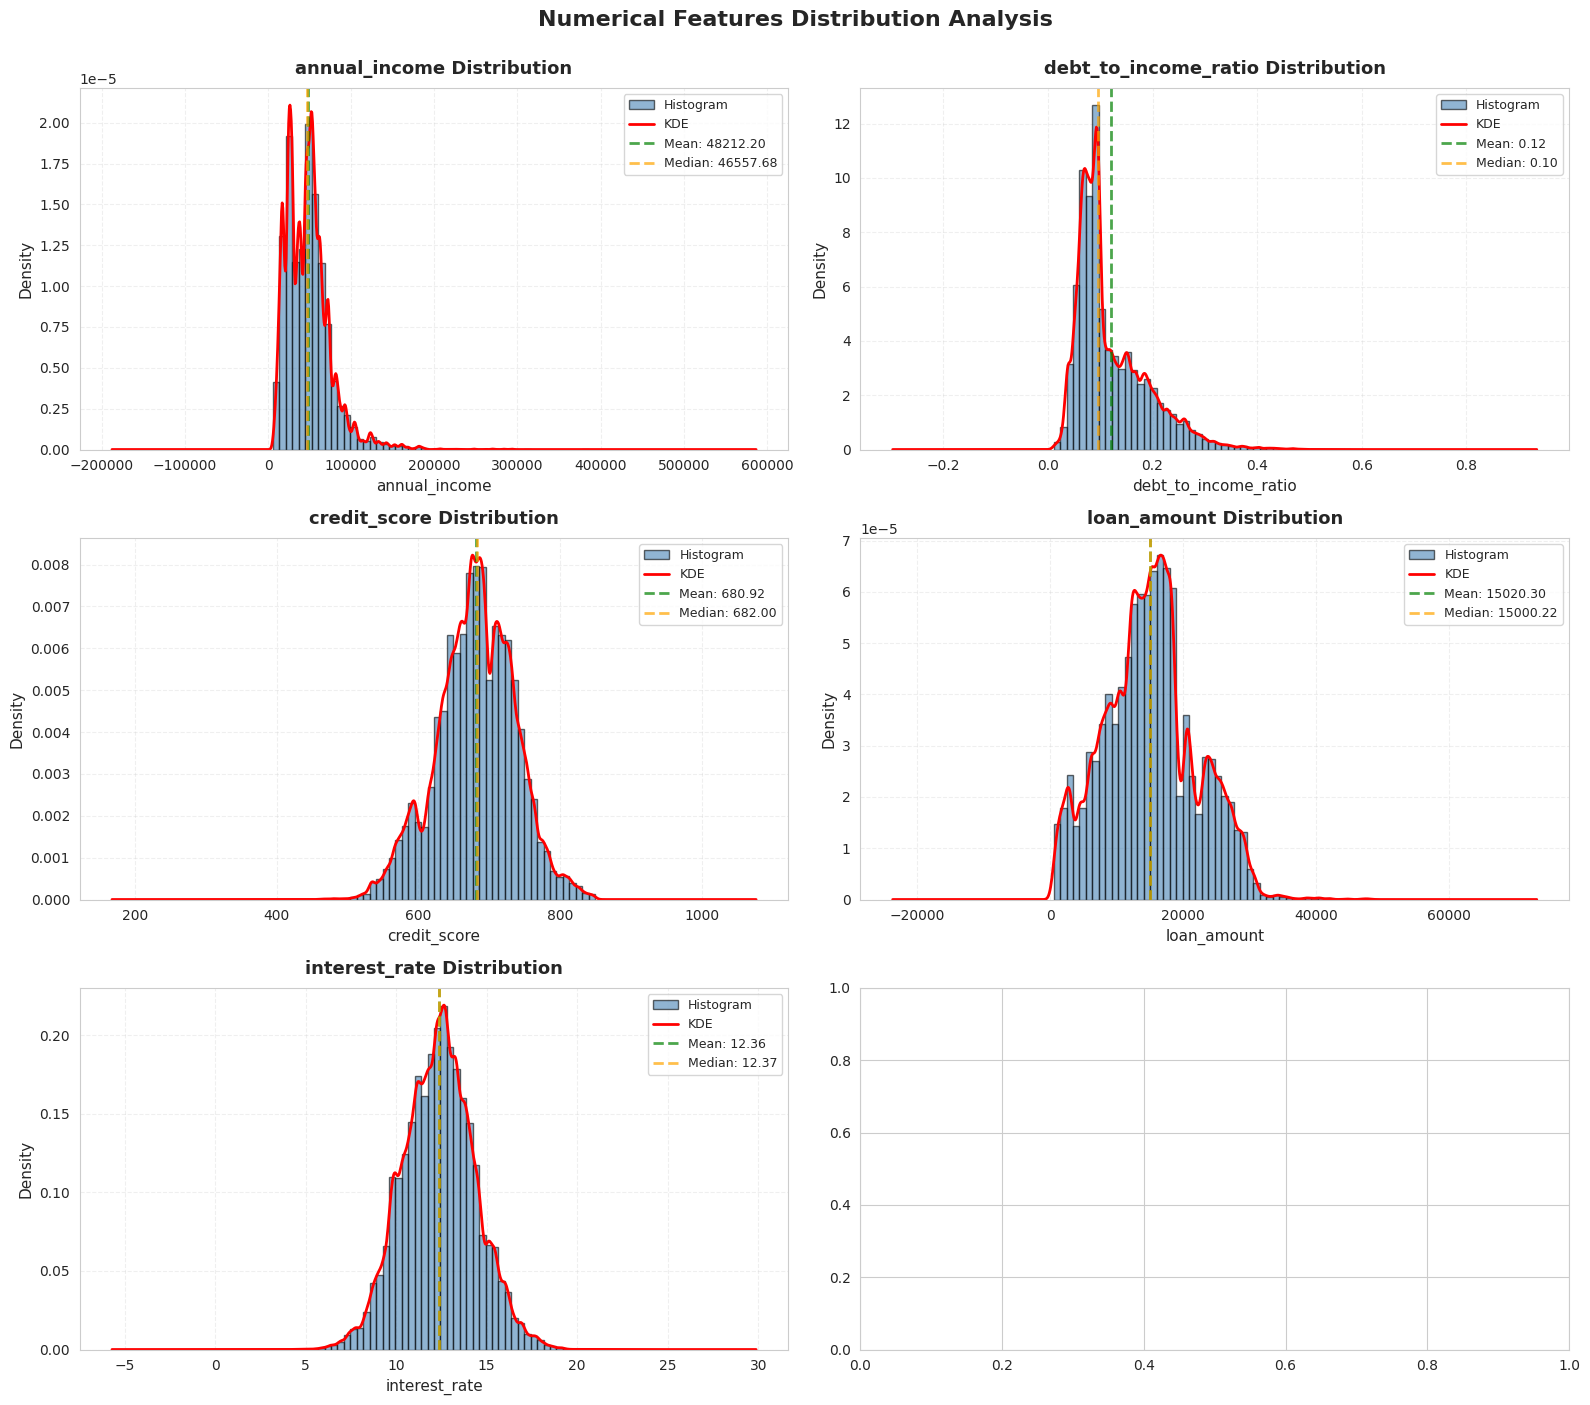

In [12]:
# Distribution of numerical features
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    # Plot distribution with KDE
    axes[idx].hist(train[col], bins=50, alpha=0.6, color='steelblue', edgecolor='black', density=True, label='Histogram')
    
    # Add KDE
    train[col].plot(kind='kde', ax=axes[idx], color='red', linewidth=2, label='KDE')
    
    axes[idx].set_title(f'{col} Distribution', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].set_ylabel('Density', fontsize=11)
    axes[idx].grid(alpha=0.3, linestyle='--')
    
    # Add statistics box
    mean_val = train[col].mean()
    median_val = train[col].median()
    std_val = train[col].std()
    
    axes[idx].axvline(mean_val, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Median: {median_val:.2f}')
    
    axes[idx].legend(fontsize=9, loc='upper right')

plt.suptitle('Numerical Features Distribution Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

CORRELATION ANALYSIS


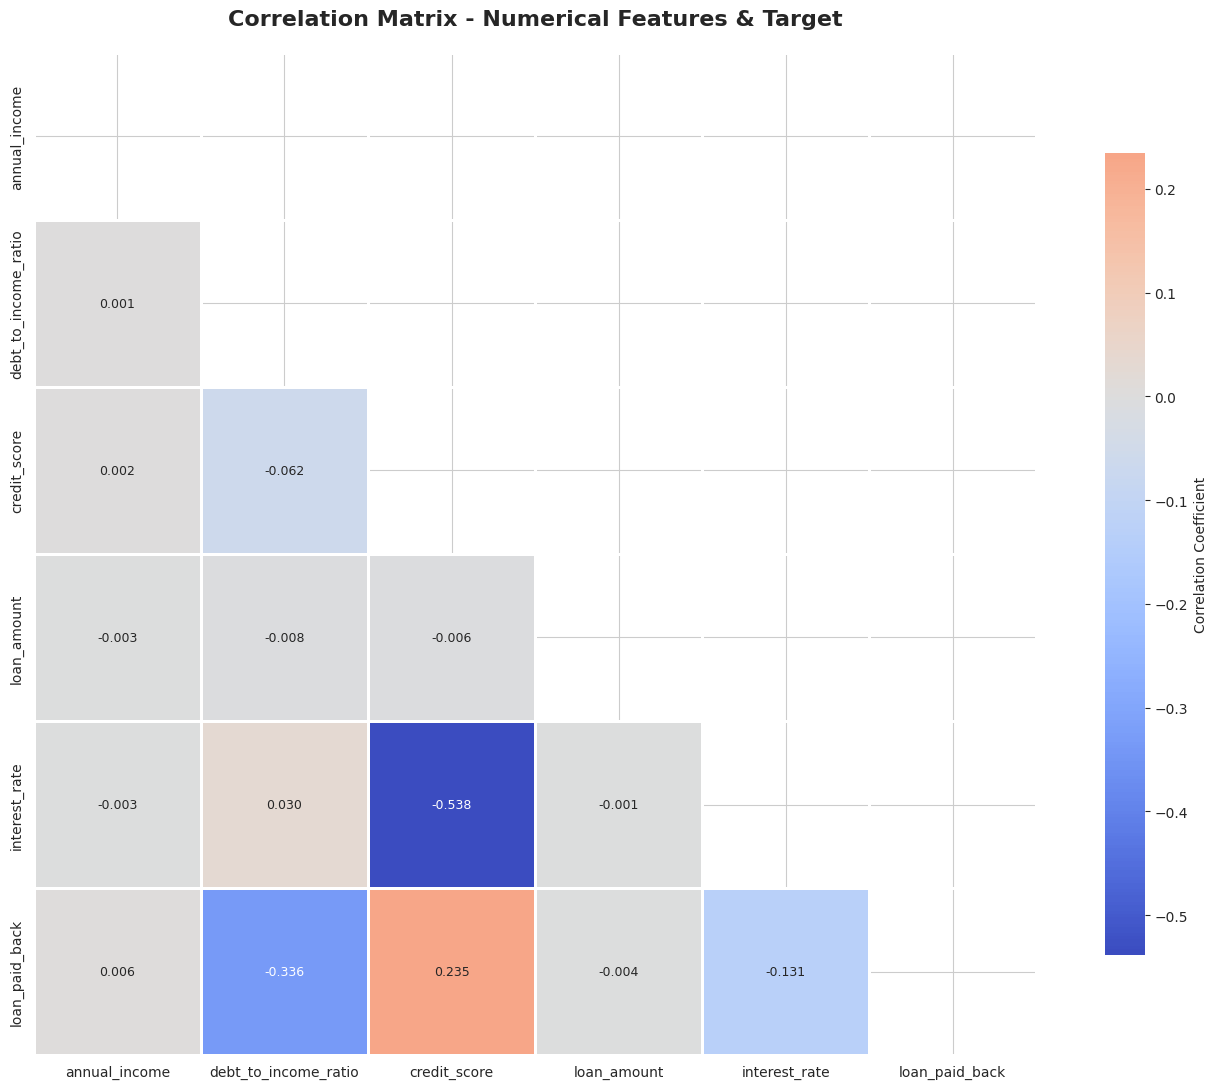


 Correlation with Target (sorted by absolute value):
   debt_to_income_ratio          : -0.3357 (abs: 0.3357)
   credit_score                  :  0.2346 (abs: 0.2346)
   interest_rate                 : -0.1312 (abs: 0.1312)
   annual_income                 :  0.0063 (abs: 0.0063)
   loan_amount                   : -0.0038 (abs: 0.0038)


In [13]:
# Correlation analysis
print("CORRELATION ANALYSIS")

plt.figure(figsize=(14, 11))
correlation_matrix = train[numerical_cols + [config.TARGET]].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create heatmap
sns.heatmap(correlation_matrix, 
            mask=mask, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            center=0, 
            square=True, 
            linewidths=1,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            annot_kws={"size": 9})

plt.title('Correlation Matrix - Numerical Features & Target', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Feature importance based on correlation with target
target_corr = correlation_matrix[config.TARGET].drop(config.TARGET).sort_values(ascending=False)

print("\n Correlation with Target (sorted by absolute value):")
target_corr_abs = target_corr.abs().sort_values(ascending=False)
for feature, corr_val in target_corr_abs.items():
    actual_corr = target_corr[feature]
    print(f"   {feature:30s}: {actual_corr:7.4f} (abs: {corr_val:.4f})")

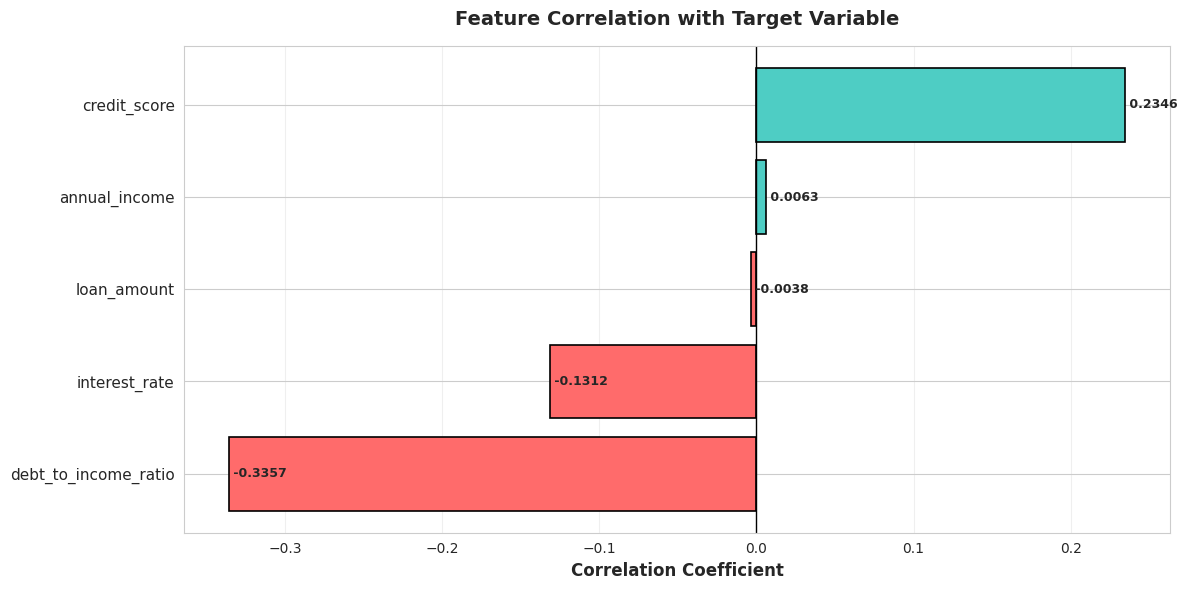

In [14]:
# Visualize correlation with target
plt.figure(figsize=(12, 6))
target_corr_df = target_corr.sort_values()
colors_list = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in target_corr_df.values]

plt.barh(range(len(target_corr_df)), target_corr_df.values, color=colors_list, edgecolor='black', linewidth=1.2)
plt.yticks(range(len(target_corr_df)), target_corr_df.index, fontsize=11)
plt.xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
plt.title('Feature Correlation with Target Variable', fontsize=14, fontweight='bold', pad=15)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(target_corr_df.values):
    plt.text(v, i, f' {v:.4f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

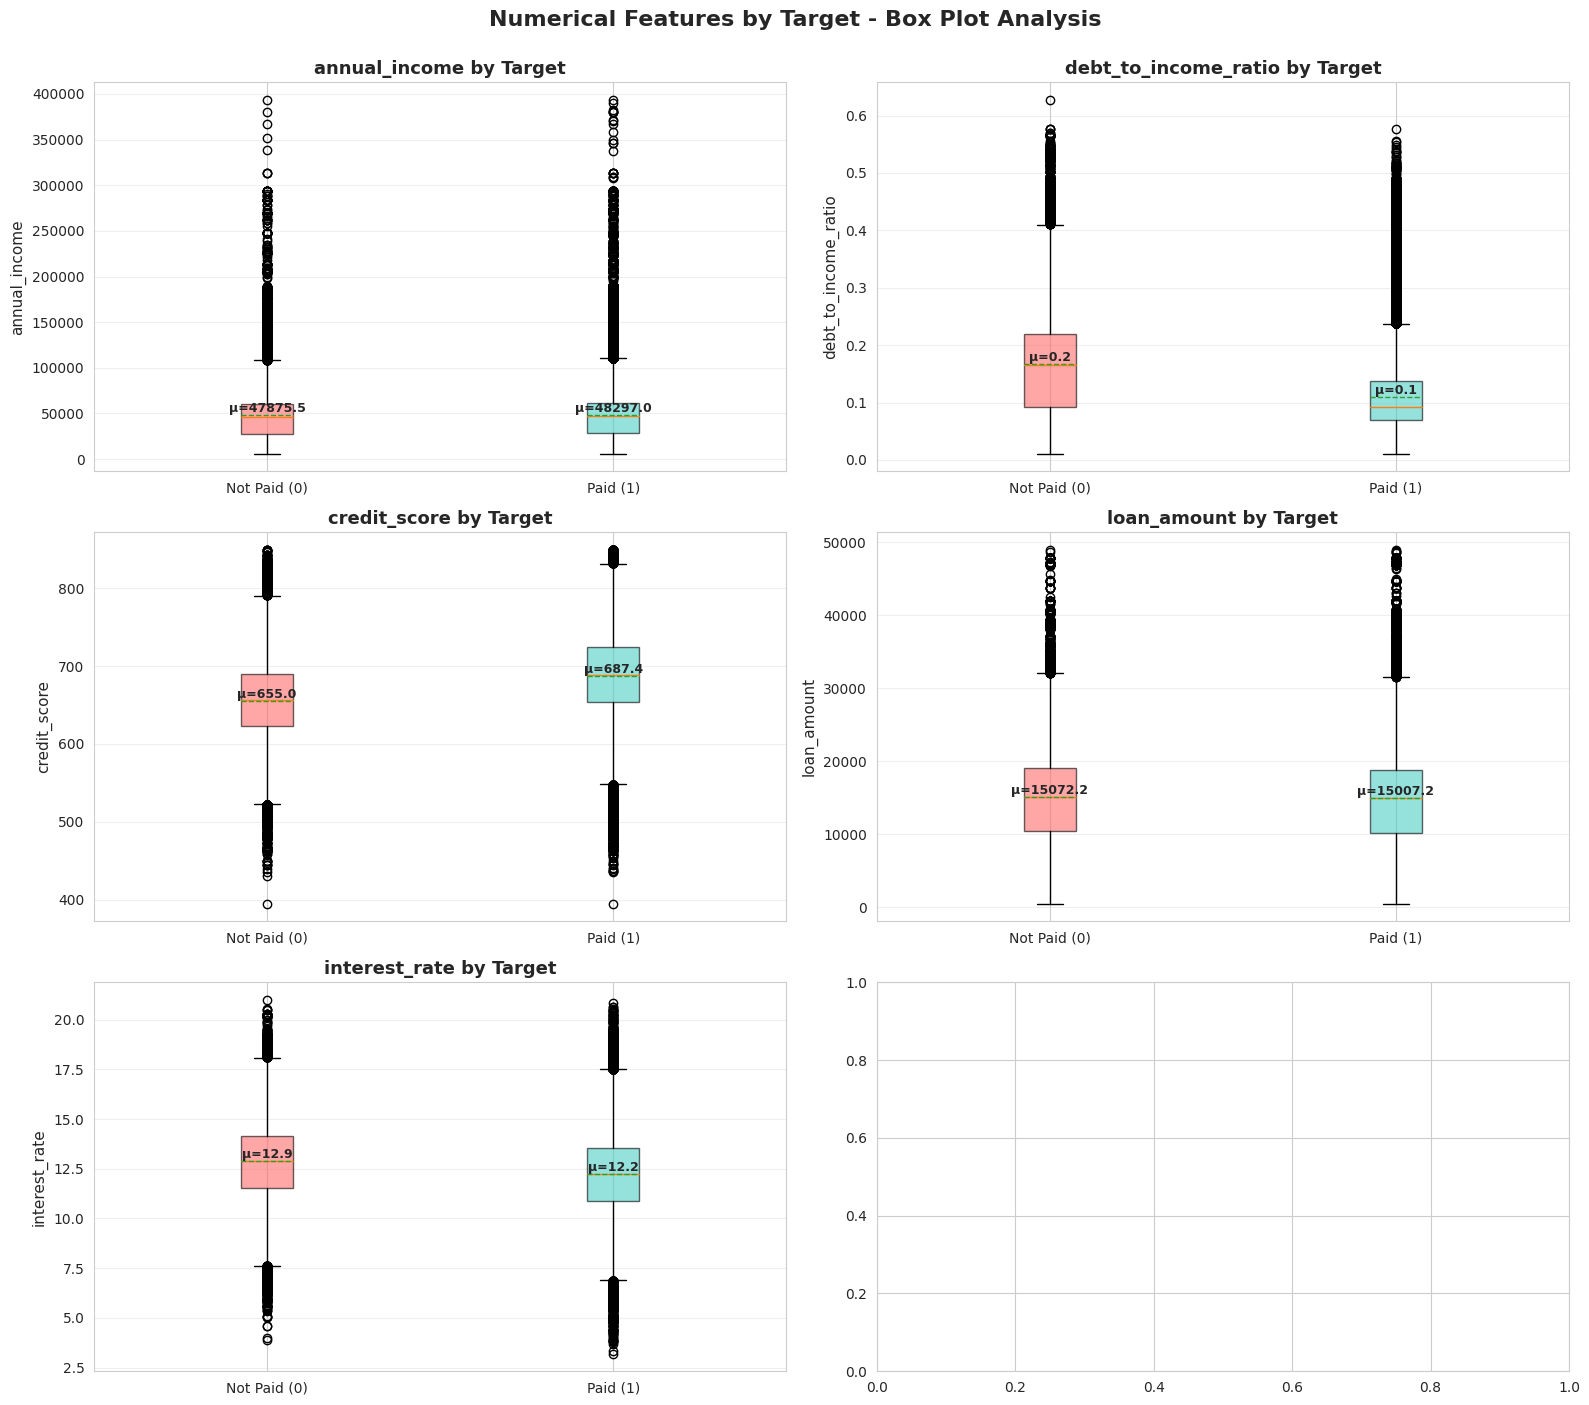

In [15]:
# Box plots by target - showing distribution differences
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    # Create box plot
    data_to_plot = [train[train[config.TARGET] == 0][col].dropna(), 
                    train[train[config.TARGET] == 1][col].dropna()]
    
    bp = axes[idx].boxplot(data_to_plot, 
                           labels=['Not Paid (0)', 'Paid (1)'],
                           patch_artist=True,
                           showmeans=True,
                           meanline=True)
    
    # Color the boxes
    colors = ['#FF6B6B', '#4ECDC4']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    axes[idx].set_title(f'{col} by Target', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel(col, fontsize=11)
    axes[idx].grid(alpha=0.3, axis='y')
    
    # Add mean values as text
    mean_0 = train[train[config.TARGET] == 0][col].mean()
    mean_1 = train[train[config.TARGET] == 1][col].mean()
    axes[idx].text(1, mean_0, f'μ={mean_0:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    axes[idx].text(2, mean_1, f'μ={mean_1:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Numerical Features by Target - Box Plot Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 3.3 Categorical Features Analysis

In [16]:
# Categorical features summary
print("CATEGORICAL FEATURES - DETAILED ANALYSIS")

for col in categorical_cols:
    print(f"Feature: {col.upper()}")
    print(f"Unique values: {train[col].nunique()}")
    print(f"Most common: {train[col].mode()[0]}")
    print(f"\nValue Counts:")
    
    value_counts_df = pd.DataFrame({
        'Value': train[col].value_counts().index,
        'Count': train[col].value_counts().values,
        'Percentage': (train[col].value_counts(normalize=True) * 100).values
    })
    display(value_counts_df.head(10).style.background_gradient(cmap='Blues', subset=['Count', 'Percentage']))

CATEGORICAL FEATURES - DETAILED ANALYSIS
Feature: GENDER
Unique values: 3
Most common: Female

Value Counts:


,Value,Count,Percentage
0,Female,306175,51.545133
1,Male,284091,47.827251
2,Other,3728,0.627616


Feature: MARITAL_STATUS
Unique values: 4
Most common: Single

Value Counts:


,Value,Count,Percentage
0,Single,288843,48.627259
1,Married,277239,46.673704
2,Divorced,21312,3.587915
3,Widowed,6600,1.111122


Feature: EDUCATION_LEVEL
Unique values: 5
Most common: Bachelor's

Value Counts:


,Value,Count,Percentage
0,Bachelor's,279606,47.072193
1,High School,183592,30.908056
2,Master's,93097,15.673054
3,Other,26677,4.491123
4,PhD,11022,1.855574


Feature: EMPLOYMENT_STATUS
Unique values: 5
Most common: Employed

Value Counts:


,Value,Count,Percentage
0,Employed,450645,75.866928
1,Unemployed,62485,10.519467
2,Self-employed,52480,8.835106
3,Retired,16453,2.769893
4,Student,11931,2.008606


Feature: LOAN_PURPOSE
Unique values: 8
Most common: Debt consolidation

Value Counts:


,Value,Count,Percentage
0,Debt consolidation,324695,54.663010
1,Other,63874,10.753307
2,Car,58108,9.782590
3,Home,44118,7.427348
4,Education,36641,6.168581
5,Business,35303,5.943326
6,Medical,22806,3.839433
7,Vacation,8449,1.422405


Feature: GRADE_SUBGRADE
Unique values: 30
Most common: C3

Value Counts:


,Value,Count,Percentage
0,C3,58695,9.881413
1,C4,55957,9.420466
2,C2,54443,9.165581
3,C1,53363,8.983761
4,C5,53317,8.976017
5,D1,37029,6.233901
6,D3,36694,6.177503
7,D4,35097,5.908646
8,D2,34432,5.796692
9,D5,32101,5.404263


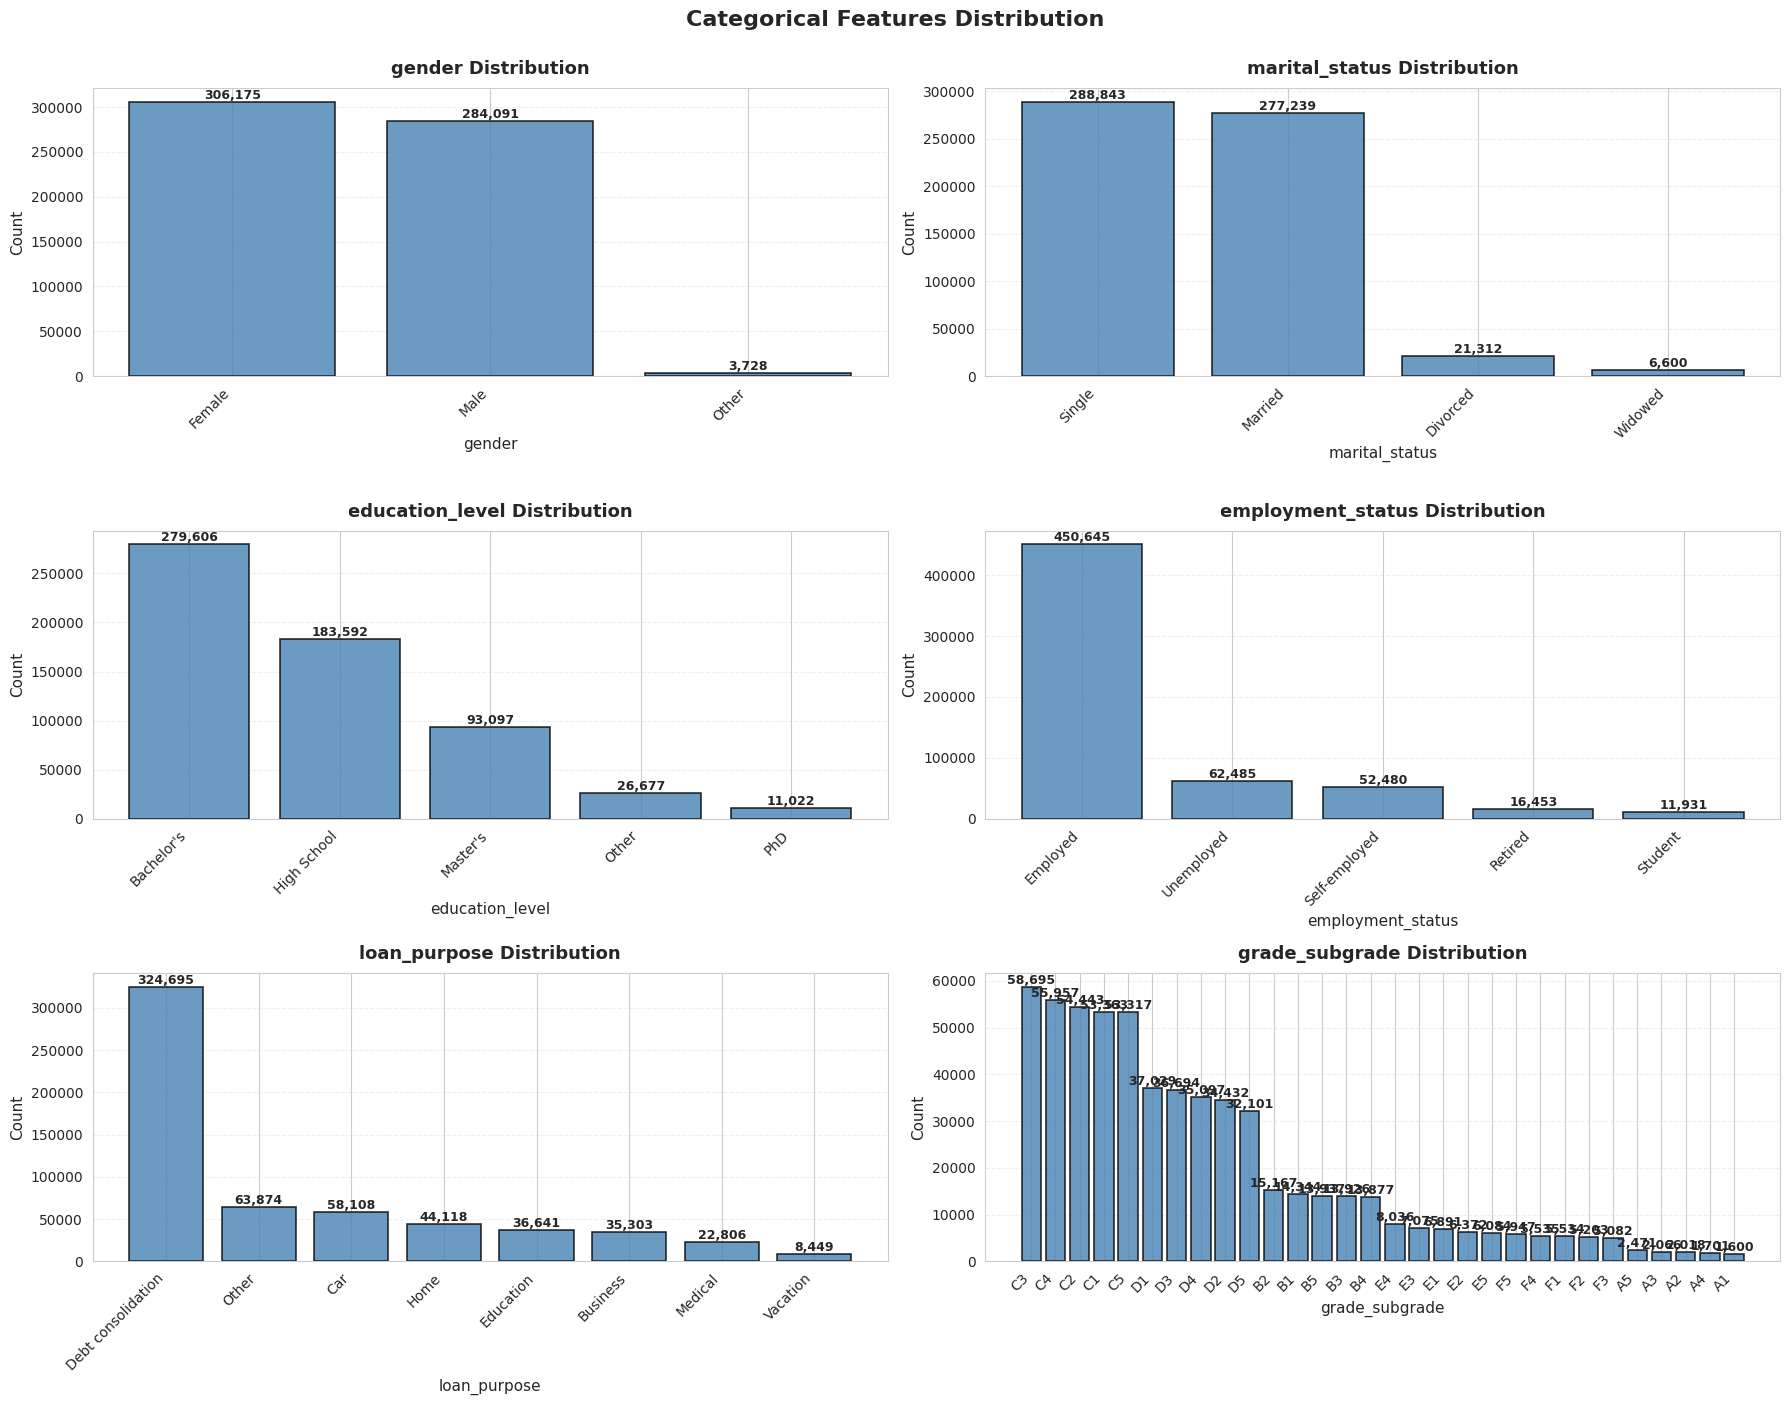

In [17]:
# Visualize categorical features distribution
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    value_counts = train[col].value_counts()
    
    # Create bar plot
    bars = axes[idx].bar(range(len(value_counts)), value_counts.values, 
                         color='steelblue', edgecolor='black', linewidth=1.2, alpha=0.8)
    
    axes[idx].set_title(f'{col} Distribution', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].set_ylabel('Count', fontsize=11)
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[idx].grid(alpha=0.3, axis='y', linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{int(height):,}',
                      ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Categorical Features Distribution', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

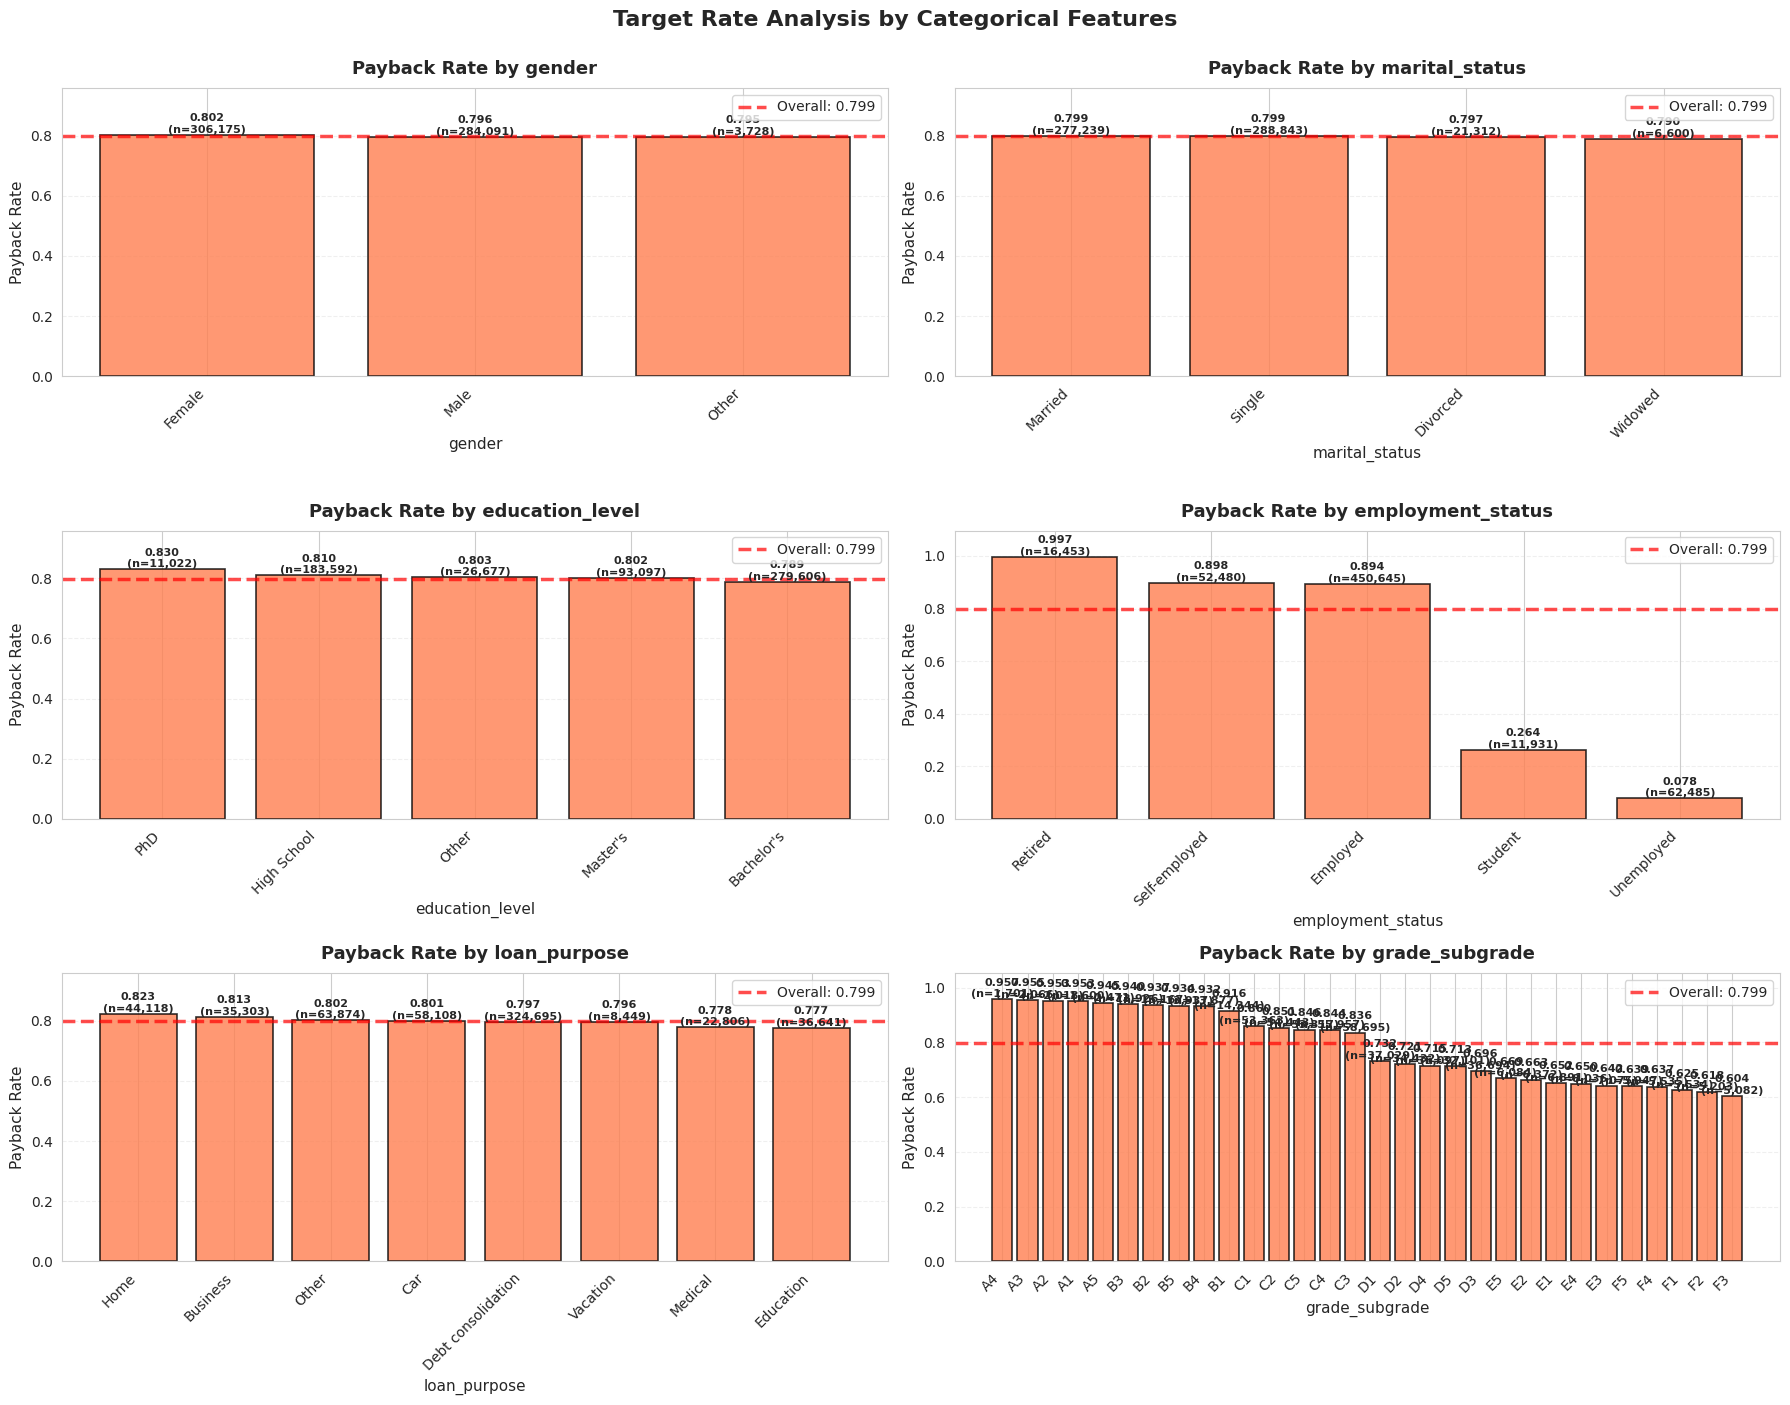

In [18]:
# Target rate by categorical features
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

overall_mean = train[config.TARGET].mean()

for idx, col in enumerate(categorical_cols):
    target_rate = train.groupby(col)[config.TARGET].agg(['mean', 'count']).sort_values('mean', ascending=False)
    
    # Create bar plot
    bars = axes[idx].bar(range(len(target_rate)), target_rate['mean'].values, 
                         color='coral', edgecolor='black', linewidth=1.2, alpha=0.8)
    
    axes[idx].set_title(f'Payback Rate by {col}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].set_ylabel('Payback Rate', fontsize=11)
    axes[idx].set_xticks(range(len(target_rate)))
    axes[idx].set_xticklabels(target_rate.index, rotation=45, ha='right')
    axes[idx].axhline(y=overall_mean, color='red', linestyle='--', 
                      linewidth=2.5, alpha=0.7, label=f'Overall: {overall_mean:.3f}')
    axes[idx].legend(fontsize=10, loc='best')
    axes[idx].grid(alpha=0.3, axis='y', linestyle='--')
    axes[idx].set_ylim([0, max(target_rate['mean'].max() * 1.1, overall_mean * 1.2)])
    
    # Add value labels with sample counts
    for i, (bar, count) in enumerate(zip(bars, target_rate['count'].values)):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}\n(n={count:,})',
                      ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.suptitle('Target Rate Analysis by Categorical Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 3.4 Advanced Statistical Analysis

In [19]:
# Skewness and Kurtosis detailed analysis
print("SKEWNESS AND KURTOSIS ANALYSIS")

skew_kurt_df = pd.DataFrame({
    'Feature': numerical_cols,
    'Skewness': [skew(train[col]) for col in numerical_cols],
    'Kurtosis': [kurtosis(train[col]) for col in numerical_cols],
    'Min': [train[col].min() for col in numerical_cols],
    'Max': [train[col].max() for col in numerical_cols],
    'Range': [train[col].max() - train[col].min() for col in numerical_cols]
})

# Add interpretation
skew_kurt_df['Skew_Interpretation'] = skew_kurt_df['Skewness'].apply(
    lambda x: 'Right-skewed' if x > 1 else ('Left-skewed' if x < -1 else 'Symmetric')
)

skew_kurt_df = skew_kurt_df.sort_values('Skewness', key=abs, ascending=False)

display(skew_kurt_df.style.background_gradient(cmap='coolwarm', subset=['Skewness', 'Kurtosis']))

print("\n Interpretation Guide:")
print("Skewness:")
print("- Close to 0: Symmetric distribution (Normal-like)")
print("- > 1: Highly right-skewed (long tail on right)")
print("- < -1: Highly left-skewed (long tail on left)")
print("\n   Kurtosis:")
print("- Close to 0: Normal-like tails")
print("- > 0: Heavy tails (more outliers)")
print("- < 0: Light tails (fewer outliers)")

SKEWNESS AND KURTOSIS ANALYSIS


,Feature,Skewness,Kurtosis,Min,Max,Range,Skew_Interpretation
0,annual_income,1.719504,7.091343,6002.430000,393381.740000,387379.310000,Right-skewed
1,debt_to_income_ratio,1.406676,2.335200,0.011000,0.627000,0.616000,Right-skewed
3,loan_amount,0.207359,-0.150151,500.090000,48959.950000,48459.860000,Symmetric
2,credit_score,-0.166992,0.095951,395.000000,849.000000,454.000000,Symmetric
4,interest_rate,0.049945,0.059787,3.200000,20.990000,17.790000,Symmetric



 Interpretation Guide:
Skewness:
- Close to 0: Symmetric distribution (Normal-like)
- > 1: Highly right-skewed (long tail on right)
- < -1: Highly left-skewed (long tail on left)

   Kurtosis:
- Close to 0: Normal-like tails
- > 0: Heavy tails (more outliers)
- < 0: Light tails (fewer outliers)


In [20]:
# Outlier detection using IQR method
print("OUTLIER DETECTION (IQR METHOD)")

outlier_summary = []

for col in numerical_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train[(train[col] < lower_bound) | (train[col] > upper_bound)][col]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(train)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Outlier_Count': outlier_count,
        'Outlier_Percentage': outlier_pct
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_Percentage', ascending=False)
display(outlier_df.style.background_gradient(cmap='Reds', subset=['Outlier_Count', 'Outlier_Percentage']))

print(f"\n Outlier Summary:")
print(f"- Total features with outliers: {(outlier_df['Outlier_Count'] > 0).sum()}")
print(f"- Average outlier percentage: {outlier_df['Outlier_Percentage'].mean():.2f}%")

OUTLIER DETECTION (IQR METHOD)


,Feature,Q1,Q3,IQR,Lower_Bound,Upper_Bound,Outlier_Count,Outlier_Percentage
1,debt_to_income_ratio,0.072000,0.156000,0.084000,-0.054000,0.282000,17556,2.955585
0,annual_income,27934.400000,60981.320000,33046.920000,-21635.980000,110551.700000,15917,2.679657
2,credit_score,646.000000,719.000000,73.000000,536.500000,828.500000,5901,0.993444
4,interest_rate,10.990000,13.680000,2.690000,6.955000,17.715000,5136,0.864655
3,loan_amount,10279.620000,18858.580000,8578.960000,-2588.820000,31727.020000,2902,0.488557



 Outlier Summary:
- Total features with outliers: 5
- Average outlier percentage: 1.60%


<a id='feature-engineering'></a>
> # 4️ Feature Engineering

## 4.1 Advanced Feature Engineering Function

In [21]:
def advanced_feature_engineering(df, is_train=True):
    """
    Comprehensive feature engineering for loan prediction
    
    This function creates multiple types of features:
    - Financial ratios and metrics
    - Risk scores and composite metrics
    - Interaction features
    - Binned/categorical versions of numerical features
    - Statistical aggregations
    - Domain-specific features
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe (train or test)
    is_train : bool
        Whether this is training data
    
    Returns:
    --------
    df : pd.DataFrame
        Dataframe with engineered features
    """
    
    df = df.copy()
    
    print("FEATURE ENGINEERING PIPELINE")
    print(f"Starting features: {df.shape[1]}")
    
    # 1. FINANCIAL RATIO FEATURES
    print("\n[1/11]  Creating financial ratio features...")
    
    # Core financial ratios
    df['loan_to_income_ratio'] = df['loan_amount'] / (df['annual_income'] + 1)
    df['monthly_income'] = df['annual_income'] / 12
    df['monthly_payment_estimate'] = (df['loan_amount'] * df['interest_rate']) / 1200
    df['payment_to_income_ratio'] = df['monthly_payment_estimate'] / (df['monthly_income'] + 1)
    
    # Debt calculations
    df['current_debt_amount'] = df['debt_to_income_ratio'] * df['annual_income']
    df['total_debt_with_loan'] = df['current_debt_amount'] + df['loan_amount']
    df['new_debt_to_income'] = df['total_debt_with_loan'] / (df['annual_income'] + 1)
    df['debt_increase_ratio'] = df['new_debt_to_income'] / (df['debt_to_income_ratio'] + 0.01)
    df['debt_increase_amount'] = df['loan_amount']
    
    # Disposable income
    df['disposable_income'] = df['annual_income'] - df['current_debt_amount']
    df['disposable_income_ratio'] = df['disposable_income'] / (df['annual_income'] + 1)
    df['loan_to_disposable_income'] = df['loan_amount'] / (df['disposable_income'] + 1)
    df['monthly_disposable_income'] = df['disposable_income'] / 12
    
    # Payment burden
    df['payment_to_disposable_ratio'] = df['monthly_payment_estimate'] / (df['monthly_disposable_income'] + 1)
    df['annual_payment_burden'] = df['monthly_payment_estimate'] * 12
    df['payment_burden_ratio'] = df['annual_payment_burden'] / (df['annual_income'] + 1)
    
    print(f"Created 16 financial ratio features")
    
    # 2. CREDIT SCORE FEATURES
    print("\n[2/11]  Creating credit score features...")
    
    # Normalize and transform credit score
    df['credit_score_normalized'] = df['credit_score'] / 850
    df['credit_risk_score'] = 1 - df['credit_score_normalized']
    df['credit_score_squared'] = df['credit_score'] ** 2
    df['credit_score_log'] = np.log1p(df['credit_score'])
    
    # Credit categories
    df['credit_category'] = pd.cut(df['credit_score'], 
                                     bins=[0, 580, 670, 740, 800, 850],
                                     labels=['poor', 'fair', 'good', 'very_good', 'excellent'])
    
    # Credit score bins
    df['credit_bin'] = pd.cut(df['credit_score'], bins=10, labels=False)
    
    # Interactions with other features
    df['credit_income_interaction'] = df['credit_score'] * df['annual_income']
    df['credit_times_dti'] = df['credit_score'] * df['debt_to_income_ratio']
    df['credit_loan_interaction'] = df['credit_score'] * df['loan_amount']
    
    print(f"Created 9 credit score features")
    
    # 3. INTEREST RATE FEATURES
    print("\n[3/11]  Creating interest rate features...")
    
    # Interest rate flags and categories
    df['high_interest_flag'] = (df['interest_rate'] > df['interest_rate'].median()).astype(int)
    df['very_high_interest'] = (df['interest_rate'] > df['interest_rate'].quantile(0.75)).astype(int)
    df['low_interest_flag'] = (df['interest_rate'] < df['interest_rate'].quantile(0.25)).astype(int)
    
    # Interest cost calculations
    df['total_interest_cost'] = df['loan_amount'] * df['interest_rate'] / 100
    df['interest_burden'] = df['total_interest_cost'] / (df['annual_income'] + 1)
    df['monthly_interest_cost'] = df['total_interest_cost'] / 12
    
    # Interest rate vs credit score (should be inversely related)
    df['interest_credit_mismatch'] = df['interest_rate'] * (1 - df['credit_score_normalized'])
    df['interest_credit_ratio'] = df['interest_rate'] / (df['credit_score'] / 100)
    
    # Interest rate transformations
    df['interest_rate_squared'] = df['interest_rate'] ** 2
    df['interest_rate_log'] = np.log1p(df['interest_rate'])
    
    print(f"Created 10 interest rate features")
    
    # 4. COMPOSITE RISK SCORES
    print("\n[4/11]   Creating composite risk scores...")
    
    # Multi-factor risk scores (weighted combinations)
    df['risk_score_v1'] = (
        df['debt_to_income_ratio'] * 0.25 +
        df['loan_to_income_ratio'] * 0.25 +
        df['credit_risk_score'] * 0.30 +
        (df['interest_rate'] / 100) * 0.20
    )
    
    df['risk_score_v2'] = (
        df['payment_to_income_ratio'] * 0.40 +
        df['new_debt_to_income'] * 0.35 +
        df['interest_burden'] * 0.25
    )
    
    df['risk_score_v3'] = (
        df['debt_to_income_ratio'] * 0.30 +
        df['payment_burden_ratio'] * 0.30 +
        df['credit_risk_score'] * 0.40
    )
    
    # Affordability score (higher is better)
    df['affordability_score'] = (
        df['credit_score_normalized'] * 0.40 +
        (1 - df['debt_to_income_ratio']) * 0.30 +
        df['disposable_income_ratio'] * 0.30
    )
    
    # Financial health score
    df['financial_health_score'] = (
        df['affordability_score'] * 0.60 -
        df['risk_score_v1'] * 0.40
    )
    
    print(f"Created 5 composite risk scores")
    
    # Continue in next cell...
    return df

<a id='feature-engineering'></a>
> # 5 Complete Feature Engineering

In [22]:
def complete_feature_engineering(df):
    """
    Comprehensive feature engineering pipeline for loan prediction
    """
    df = df.copy()
    
    print(" FEATURE ENGINEERING PIPELINE")
    print(f"Starting features: {df.shape[1]}")
    
    # 1. FINANCIAL RATIOS
    print("\n[1/12]  Financial ratio features...")
    df['loan_to_income_ratio'] = df['loan_amount'] / (df['annual_income'] + 1)
    df['monthly_income'] = df['annual_income'] / 12
    df['monthly_payment_estimate'] = (df['loan_amount'] * df['interest_rate']) / 1200
    df['payment_to_income_ratio'] = df['monthly_payment_estimate'] / (df['monthly_income'] + 1)
    df['current_debt_amount'] = df['debt_to_income_ratio'] * df['annual_income']
    df['total_debt_with_loan'] = df['current_debt_amount'] + df['loan_amount']
    df['new_debt_to_income'] = df['total_debt_with_loan'] / (df['annual_income'] + 1)
    df['debt_increase_ratio'] = df['new_debt_to_income'] / (df['debt_to_income_ratio'] + 0.01)
    df['disposable_income'] = df['annual_income'] - df['current_debt_amount']
    df['disposable_income_ratio'] = df['disposable_income'] / (df['annual_income'] + 1)
    df['loan_to_disposable_income'] = df['loan_amount'] / (df['disposable_income'] + 1)
    df['monthly_disposable_income'] = df['disposable_income'] / 12
    df['payment_to_disposable_ratio'] = df['monthly_payment_estimate'] / (df['monthly_disposable_income'] + 1)
    df['annual_payment_burden'] = df['monthly_payment_estimate'] * 12
    df['payment_burden_ratio'] = df['annual_payment_burden'] / (df['annual_income'] + 1)
    
    # New ratio features
    df['debt_coverage_ratio'] = df['monthly_income'] / (df['current_debt_amount'] / 12 + 1)
    df['interest_to_income_ratio'] = (df['loan_amount'] * df['interest_rate'] / 100) / (df['annual_income'] + 1)
    print(f"Created 17 features")
    
    # 2. CREDIT SCORE FEATURES
    print("[2/12]  Credit score features...")
    df['credit_score_normalized'] = df['credit_score'] / 850
    df['credit_risk_score'] = 1 - df['credit_score_normalized']
    df['credit_score_squared'] = df['credit_score'] ** 2
    df['credit_score_log'] = np.log1p(df['credit_score'])
    df['credit_score_sqrt'] = np.sqrt(df['credit_score'])
    df['credit_category'] = pd.cut(df['credit_score'], bins=[0, 580, 670, 740, 800, 850],
                                     labels=['poor', 'fair', 'good', 'very_good', 'excellent'])
    df['credit_income_interaction'] = df['credit_score'] * df['annual_income']
    df['credit_times_dti'] = df['credit_score'] * df['debt_to_income_ratio']
    df['credit_loan_interaction'] = df['credit_score'] * df['loan_amount']
    df['credit_per_dollar'] = df['credit_score'] / (df['loan_amount'] + 1)
    print(f"Created 10 features")
    
    # 3. INTEREST RATE FEATURES
    print("[3/12]  Interest rate features...")
    df['high_interest_flag'] = (df['interest_rate'] > df['interest_rate'].median()).astype(int)
    df['very_high_interest'] = (df['interest_rate'] > df['interest_rate'].quantile(0.75)).astype(int)
    df['low_interest_flag'] = (df['interest_rate'] < df['interest_rate'].quantile(0.25)).astype(int)
    df['total_interest_cost'] = df['loan_amount'] * df['interest_rate'] / 100
    df['interest_burden'] = df['total_interest_cost'] / (df['annual_income'] + 1)
    df['interest_credit_mismatch'] = df['interest_rate'] * (1 - df['credit_score_normalized'])
    df['interest_credit_ratio'] = df['interest_rate'] / (df['credit_score'] / 100)
    df['interest_rate_squared'] = df['interest_rate'] ** 2
    df['interest_rate_sqrt'] = np.sqrt(df['interest_rate'])
    df['interest_income_burden'] = df['interest_rate'] * df['loan_to_income_ratio']
    print(f"Created 10 features")
    
    # 4. RISK SCORES
    print("[4/12]   Composite risk scores...")
    df['risk_score_v1'] = (df['debt_to_income_ratio'] * 0.25 + df['loan_to_income_ratio'] * 0.25 +
                           df['credit_risk_score'] * 0.30 + (df['interest_rate'] / 100) * 0.20)
    df['risk_score_v2'] = (df['payment_to_income_ratio'] * 0.40 + df['new_debt_to_income'] * 0.35 +
                           df['interest_burden'] * 0.25)
    df['risk_score_v3'] = (df['debt_to_income_ratio'] * 0.30 + df['payment_burden_ratio'] * 0.30 +
                           df['credit_risk_score'] * 0.40)
    df['affordability_score'] = (df['credit_score_normalized'] * 0.40 + 
                                 (1 - df['debt_to_income_ratio']) * 0.30 +
                                 df['disposable_income_ratio'] * 0.30)
    df['financial_health_score'] = df['affordability_score'] * 0.60 - df['risk_score_v1'] * 0.40
    
    # Advanced composite scores
    df['payment_stress_score'] = (df['payment_to_income_ratio'] * 0.4 + 
                                   df['debt_increase_ratio'] * 0.3 +
                                   df['interest_burden'] * 0.3)
    df['creditworthiness_score'] = df['credit_score_normalized'] * 0.7 - df['risk_score_v1'] * 0.3
    print(f"Created 7 features")
    
    # 5. LOAN AMOUNT FEATURES
    print("[5/12]  Loan amount features...")
    df['loan_size'] = pd.cut(df['loan_amount'], bins=[0, 10000, 20000, 30000, np.inf],
                              labels=['small', 'medium', 'large', 'very_large'])
    df['loan_amount_squared'] = df['loan_amount'] ** 2
    df['loan_amount_log'] = np.log1p(df['loan_amount'])
    df['annual_income_log'] = np.log1p(df['annual_income'])
    df['loan_amount_sqrt'] = np.sqrt(df['loan_amount'])
    df['loan_per_income_unit'] = df['loan_amount'] / (df['annual_income'] / 10000 + 1)
    print(f"Created 6 features")
    
    # 6. BINNING FEATURES
    print("[6/12]  Binned features...")
    df['income_decile'] = pd.qcut(df['annual_income'], q=10, labels=False, duplicates='drop')
    df['credit_decile'] = pd.qcut(df['credit_score'], q=10, labels=False, duplicates='drop')
    df['loan_decile'] = pd.qcut(df['loan_amount'], q=10, labels=False, duplicates='drop')
    df['dti_decile'] = pd.qcut(df['debt_to_income_ratio'], q=10, labels=False, duplicates='drop')
    df['interest_decile'] = pd.qcut(df['interest_rate'], q=10, labels=False, duplicates='drop')
    df['income_quintile'] = pd.qcut(df['annual_income'], q=5, labels=False, duplicates='drop')
    df['credit_quintile'] = pd.qcut(df['credit_score'], q=5, labels=False, duplicates='drop')
    print(f"Created 7 features")
    
    # 7. INTERACTION FEATURES
    print("[7/12]  Interaction features...")
    df['income_x_credit'] = df['annual_income'] * df['credit_score']
    df['dti_x_interest'] = df['debt_to_income_ratio'] * df['interest_rate']
    df['loan_x_interest'] = df['loan_amount'] * df['interest_rate']
    df['income_x_dti'] = df['annual_income'] * df['debt_to_income_ratio']
    df['income_credit_loan'] = df['annual_income'] * df['credit_score'] * df['loan_amount']
    df['dti_interest_credit'] = df['debt_to_income_ratio'] * df['interest_rate'] * df['credit_score']
    
    # More powerful interactions
    df['income_sqrt_x_credit'] = np.sqrt(df['annual_income']) * df['credit_score']
    df['loan_sqrt_x_interest'] = np.sqrt(df['loan_amount']) * df['interest_rate']
    df['log_income_x_credit'] = df['annual_income_log'] * df['credit_score_log']
    print(f"Created 9 features")
    
    # 8. GRADE FEATURES
    print("[8/12]  Grade/subgrade features...")
    df['grade'] = df['grade_subgrade'].str[0]
    df['subgrade_num'] = df['grade_subgrade'].str[1:].astype(int)
    grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    df['grade_numeric'] = df['grade'].map(grade_map)
    df['full_grade_score'] = df['grade_numeric'] * 10 + df['subgrade_num']
    df['grade_credit_ratio'] = df['full_grade_score'] / (df['credit_score'] / 100)
    df['grade_interest_ratio'] = df['full_grade_score'] / (df['interest_rate'] + 1)
    df['grade_risk_weighted'] = df['full_grade_score'] * df['loan_to_income_ratio']
    print(f"Created 7 features")
    
    # 9. STATISTICAL AGGREGATIONS
    print("[9/12]  Statistical aggregations...")
    df['mean_financial_metrics'] = df[['debt_to_income_ratio', 'loan_to_income_ratio', 
                                        'payment_to_income_ratio']].mean(axis=1)
    df['max_financial_burden'] = df[['debt_to_income_ratio', 'loan_to_income_ratio', 
                                      'payment_to_income_ratio']].max(axis=1)
    df['min_financial_burden'] = df[['debt_to_income_ratio', 'loan_to_income_ratio', 
                                      'payment_to_income_ratio']].min(axis=1)
    df['std_financial_metrics'] = df[['debt_to_income_ratio', 'loan_to_income_ratio', 
                                       'payment_to_income_ratio']].std(axis=1)
    df['range_financial_burden'] = df['max_financial_burden'] - df['min_financial_burden']
    df['cv_financial_metrics'] = df['std_financial_metrics'] / (df['mean_financial_metrics'] + 1e-6)
    print(f"Created 6 features")
    
    # 10. CATEGORICAL COMBINATIONS
    print("[10/12]  Categorical combinations...")
    df['gender_marital'] = df['gender'] + '_' + df['marital_status']
    df['education_employment'] = df['education_level'] + '_' + df['employment_status']
    df['gender_education'] = df['gender'] + '_' + df['education_level']
    df['marital_employment'] = df['marital_status'] + '_' + df['employment_status']
    df['purpose_grade'] = df['loan_purpose'] + '_' + df['grade']
    df['employment_purpose'] = df['employment_status'] + '_' + df['loan_purpose']
    df['education_marital'] = df['education_level'] + '_' + df['marital_status']
    print(f"Created 7 features")
    
    # 11. ANOMALY FLAGS
    print("[11/12]  Anomaly detection flags...")
    df['extreme_dti'] = (df['debt_to_income_ratio'] > df['debt_to_income_ratio'].quantile(0.90)).astype(int)
    df['low_income'] = (df['annual_income'] < df['annual_income'].quantile(0.25)).astype(int)
    df['large_loan'] = (df['loan_amount'] > df['loan_amount'].quantile(0.75)).astype(int)
    df['risky_combo_1'] = ((df['debt_to_income_ratio'] > 0.4) & (df['credit_score'] < 650)).astype(int)
    df['risky_combo_2'] = ((df['loan_to_income_ratio'] > 0.5) & (df['interest_rate'] > 15)).astype(int)
    df['risky_combo_3'] = ((df['extreme_dti'] == 1) & (df['low_interest_flag'] == 0)).astype(int)
    df['safe_combo'] = ((df['credit_score'] > 750) & (df['debt_to_income_ratio'] < 0.3)).astype(int)
    df['high_risk_all'] = (df['extreme_dti'] & df['risky_combo_1']).astype(int)
    df['low_credit_high_loan'] = ((df['credit_score'] < 600) & (df['large_loan'] == 1)).astype(int)
    df['perfect_profile'] = ((df['credit_score'] > 800) & (df['debt_to_income_ratio'] < 0.2)).astype(int)
    print(f"Created 10 features")
    
    # 12. POLYNOMIAL AND RATIO COMBINATIONS
    print("[12/12]  Advanced polynomial features...")
    df['dti_squared'] = df['debt_to_income_ratio'] ** 2
    df['dti_cubed'] = df['debt_to_income_ratio'] ** 3
    df['loan_income_product'] = df['loan_amount'] * df['annual_income']
    df['loan_credit_product'] = df['loan_amount'] * df['credit_score']
    df['payment_income_squared'] = df['payment_to_income_ratio'] ** 2
    df['risk_adjusted_loan'] = df['loan_amount'] * df['credit_risk_score']
    df['efficiency_ratio'] = df['credit_score'] / (df['interest_rate'] * df['debt_to_income_ratio'] + 1)
    print(f"Created 7 features")
    
    print(f" Feature Engineering Complete!")
    print(f"Final features: {df.shape[1]}")
    print(f"New features: {df.shape[1] - 13}")
    
    return df

# Apply feature engineering
train_fe = complete_feature_engineering(train)
test_fe = complete_feature_engineering(test)

 FEATURE ENGINEERING PIPELINE
Starting features: 13

[1/12]  Financial ratio features...
Created 17 features
[2/12]  Credit score features...
Created 10 features
[3/12]  Interest rate features...
Created 10 features
[4/12]   Composite risk scores...
Created 7 features
[5/12]  Loan amount features...
Created 6 features
[6/12]  Binned features...
Created 7 features
[7/12]  Interaction features...
Created 9 features
[8/12]  Grade/subgrade features...
Created 7 features
[9/12]  Statistical aggregations...
Created 6 features
[10/12]  Categorical combinations...
Created 7 features
[11/12]  Anomaly detection flags...
Created 10 features
[12/12]  Advanced polynomial features...
Created 7 features
 Feature Engineering Complete!
Final features: 116
New features: 103
 FEATURE ENGINEERING PIPELINE
Starting features: 12

[1/12]  Financial ratio features...
Created 17 features
[2/12]  Credit score features...
Created 10 features
[3/12]  Interest rate features...
Created 10 features
[4/12]   Composit

In [23]:
# Encode categorical features
print("ENCODING CATEGORICAL FEATURES")

categorical_features = train_fe.select_dtypes(include=['object', 'category']).columns.tolist()

le_dict = {}
for col in categorical_features:
    le = LabelEncoder()
    train_fe[col] = le.fit_transform(train_fe[col].astype(str))
    test_fe[col] = le.transform(test_fe[col].astype(str))
    le_dict[col] = le
    print(f"{col}: {len(le.classes_)} classes")

print(f"\n Encoded {len(categorical_features)} features")

ENCODING CATEGORICAL FEATURES
gender: 3 classes
marital_status: 4 classes
education_level: 5 classes
employment_status: 5 classes
loan_purpose: 8 classes
grade_subgrade: 30 classes
credit_category: 5 classes
loan_size: 4 classes
grade: 6 classes
gender_marital: 12 classes
education_employment: 25 classes
gender_education: 15 classes
marital_employment: 20 classes
purpose_grade: 48 classes
employment_purpose: 40 classes
education_marital: 20 classes

 Encoded 16 features


In [24]:
# Prepare datasets
feature_cols = [col for col in train_fe.columns if col not in ['id', config.TARGET]]

X = train_fe[feature_cols]
y = train_fe[config.TARGET]
X_test = test_fe[feature_cols]
test_ids = test_fe['id']

print("FINAL DATA READY")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"X_test: {X_test.shape}")
print(f"Features: {len(feature_cols)}")

FINAL DATA READY
X: (593994, 114)
y: (593994,)
X_test: (254569, 114)
Features: 114


<a id='model-training'></a>
> # 6 Model Training

## 6.1 LightGBM

In [25]:
def train_lightgbm(X, y, X_test, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    feature_importance = pd.DataFrame()
    
    # Improved LightGBM parameters for better performance
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 64,  # Increased for more complex patterns
        'learning_rate': 0.03,  # Slightly lower for better generalization
        'feature_fraction': 0.7,  # More conservative
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'max_depth': 8,  # Deeper trees
        'min_child_samples': 25,
        'reg_alpha': 0.5,  # Stronger regularization
        'reg_lambda': 0.5,
        'min_split_gain': 0.01,  # Prevent overfitting
        'max_bin': 255,
        'random_state': SEED,
        'verbose': -1,
        'n_jobs': -1
    }
    
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        model = lgb.train(
            params, train_data, num_boost_round=3000,  # More rounds
            valid_sets=[train_data, val_data],
            callbacks=[lgb.early_stopping(150), lgb.log_evaluation(200)]  # More patience
        )
        
        oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
        test_preds += model.predict(X_test, num_iteration=model.best_iteration) / n_splits
        
        score = roc_auc_score(y_val, oof_preds[val_idx])
        fold_scores.append(score)
        print(f"Fold {fold + 1} AUC: {score:.6f}")
        
        fold_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importance(importance_type='gain'),
            'fold': fold + 1
        })
        feature_importance = pd.concat([feature_importance, fold_importance])
    
    overall_score = roc_auc_score(y, oof_preds)
    print(f"\n{'='*80}")
    print(f"LightGBM OOF AUC: {overall_score:.6f}")
    print(f"Mean: {np.mean(fold_scores):.6f} (+/- {np.std(fold_scores):.6f})")
    print(f"{'='*80}")
    
    return oof_preds, test_preds, feature_importance, overall_score

print("\n Training LightGBM...")
lgb_oof, lgb_test, lgb_importance, lgb_score = train_lightgbm(X, y, X_test, n_splits=config.N_SPLITS)


 Training LightGBM...
Fold 1/5
Training until validation scores don't improve for 150 rounds
[200]	training's auc: 0.920983	valid_1's auc: 0.918587
[400]	training's auc: 0.927741	valid_1's auc: 0.920841
[600]	training's auc: 0.93286	valid_1's auc: 0.921623
[800]	training's auc: 0.937265	valid_1's auc: 0.922043
Early stopping, best iteration is:
[771]	training's auc: 0.936683	valid_1's auc: 0.922075
Fold 1 AUC: 0.922075
Fold 2/5
Training until validation scores don't improve for 150 rounds
[200]	training's auc: 0.921251	valid_1's auc: 0.917935
[400]	training's auc: 0.927544	valid_1's auc: 0.920064
[600]	training's auc: 0.932541	valid_1's auc: 0.920704
[800]	training's auc: 0.937051	valid_1's auc: 0.921148
[1000]	training's auc: 0.940922	valid_1's auc: 0.921399
[1200]	training's auc: 0.944578	valid_1's auc: 0.921559
Early stopping, best iteration is:
[1177]	training's auc: 0.944194	valid_1's auc: 0.921573
Fold 2 AUC: 0.921573
Fold 3/5
Training until validation scores don't improve for 1

## 6.2 XGBoost

In [26]:
def train_xgboost(X, y, X_test, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    
    # Improved XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 7,  # Deeper trees
        'learning_rate': 0.03,  # Lower learning rate
        'subsample': 0.75,
        'colsample_bytree': 0.75,
        'colsample_bylevel': 0.75,
        'min_child_weight': 3,
        'reg_alpha': 0.3,  # L1 regularization
        'reg_lambda': 1.5,  # L2 regularization
        'gamma': 0.1,  # Minimum loss reduction
        'random_state': SEED,
        'tree_method': 'hist',
        'max_bin': 256,
        'n_jobs': -1
    }
    
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params, n_estimators=3000)  # More estimators
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=150,  # More patience
            verbose=200
        )
        
        best_it = getattr(model, "best_iteration", None)
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / n_splits
        
        score = roc_auc_score(y_val, oof_preds[val_idx])
        fold_scores.append(score)
        print(f"Fold {fold + 1} AUC: {score:.6f}")
    
    overall_score = roc_auc_score(y, oof_preds)
    print(f"\nXGBoost OOF AUC: {overall_score:.6f}")
    print(f"Mean: {np.mean(fold_scores):.6f} (+/- {np.std(fold_scores):.6f})")
    
    return oof_preds, test_preds, overall_score

print("\n Training XGBoost...")
xgb_oof, xgb_test, xgb_score = train_xgboost(X, y, X_test, n_splits=config.N_SPLITS)


 Training XGBoost...

Fold 1/5
[0]	validation_0-auc:0.91010
[200]	validation_0-auc:0.91812
[400]	validation_0-auc:0.92044
[600]	validation_0-auc:0.92122
[800]	validation_0-auc:0.92149
[1000]	validation_0-auc:0.92165
[1200]	validation_0-auc:0.92168
[1248]	validation_0-auc:0.92170
Fold 1 AUC: 0.921748

Fold 2/5
[0]	validation_0-auc:0.90956
[200]	validation_0-auc:0.91728
[400]	validation_0-auc:0.91952
[600]	validation_0-auc:0.92038
[800]	validation_0-auc:0.92075
[1000]	validation_0-auc:0.92100
[1200]	validation_0-auc:0.92094
[1216]	validation_0-auc:0.92092
Fold 2 AUC: 0.921040

Fold 3/5
[0]	validation_0-auc:0.90837
[200]	validation_0-auc:0.91597
[400]	validation_0-auc:0.91822
[600]	validation_0-auc:0.91905
[800]	validation_0-auc:0.91950
[1000]	validation_0-auc:0.91962
[1061]	validation_0-auc:0.91967
Fold 3 AUC: 0.919692

Fold 4/5
[0]	validation_0-auc:0.90903
[200]	validation_0-auc:0.91689
[400]	validation_0-auc:0.91927
[600]	validation_0-auc:0.92006
[800]	validation_0-auc:0.92042
[1000]	

## 6.3 CatBoost

In [27]:
def train_catboost(X, y, X_test, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    
    # Improved CatBoost parameters
    params = {
        'iterations': 3000,  # More iterations
        'learning_rate': 0.03,  # Lower learning rate
        'depth': 7,  # Deeper trees
        'l2_leaf_reg': 5,  # Stronger regularization
        'bagging_temperature': 0.5,  # Bayesian bootstrap
        'random_strength': 0.5,
        'border_count': 128,
        'random_seed': SEED,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'early_stopping_rounds': 150,  # More patience
        'verbose': 200,
        'task_type': 'CPU'
    }
    
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
        
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / n_splits
        
        score = roc_auc_score(y_val, oof_preds[val_idx])
        fold_scores.append(score)
        print(f"Fold {fold + 1} AUC: {score:.6f}")
    
    overall_score = roc_auc_score(y, oof_preds)
    print(f"\nCatBoost OOF AUC: {overall_score:.6f}")
    print(f"Mean: {np.mean(fold_scores):.6f} (+/- {np.std(fold_scores):.6f})")
    
    return oof_preds, test_preds, overall_score

print("\n Training CatBoost...")
cat_oof, cat_test, cat_score = train_catboost(X, y, X_test, n_splits=config.N_SPLITS)


 Training CatBoost...

Fold 1/5
0:	test: 0.8997643	best: 0.8997643 (0)	total: 194ms	remaining: 9m 41s
200:	test: 0.9159420	best: 0.9159420 (200)	total: 25.6s	remaining: 5m 56s
400:	test: 0.9174431	best: 0.9174431 (400)	total: 51.1s	remaining: 5m 31s
600:	test: 0.9181551	best: 0.9181551 (600)	total: 1m 16s	remaining: 5m 7s
800:	test: 0.9187438	best: 0.9187438 (800)	total: 1m 42s	remaining: 4m 40s
1000:	test: 0.9192599	best: 0.9192599 (1000)	total: 2m 7s	remaining: 4m 15s
1200:	test: 0.9195891	best: 0.9195891 (1200)	total: 2m 33s	remaining: 3m 49s
1400:	test: 0.9197496	best: 0.9197496 (1400)	total: 2m 59s	remaining: 3m 24s
1600:	test: 0.9199891	best: 0.9199891 (1600)	total: 3m 24s	remaining: 2m 59s
1800:	test: 0.9201263	best: 0.9201283 (1799)	total: 3m 50s	remaining: 2m 33s
2000:	test: 0.9201918	best: 0.9201954 (1989)	total: 4m 15s	remaining: 2m 7s
2200:	test: 0.9202805	best: 0.9202829 (2188)	total: 4m 41s	remaining: 1m 42s
2400:	test: 0.9203680	best: 0.9203709 (2382)	total: 5m 6s	remai

<a id='evaluation'></a>
> # 7 Model Evaluation

MODEL COMPARISON


,Model,OOF AUC
0,LightGBM,0.920970
1,XGBoost,0.920610
2,CatBoost,0.919083


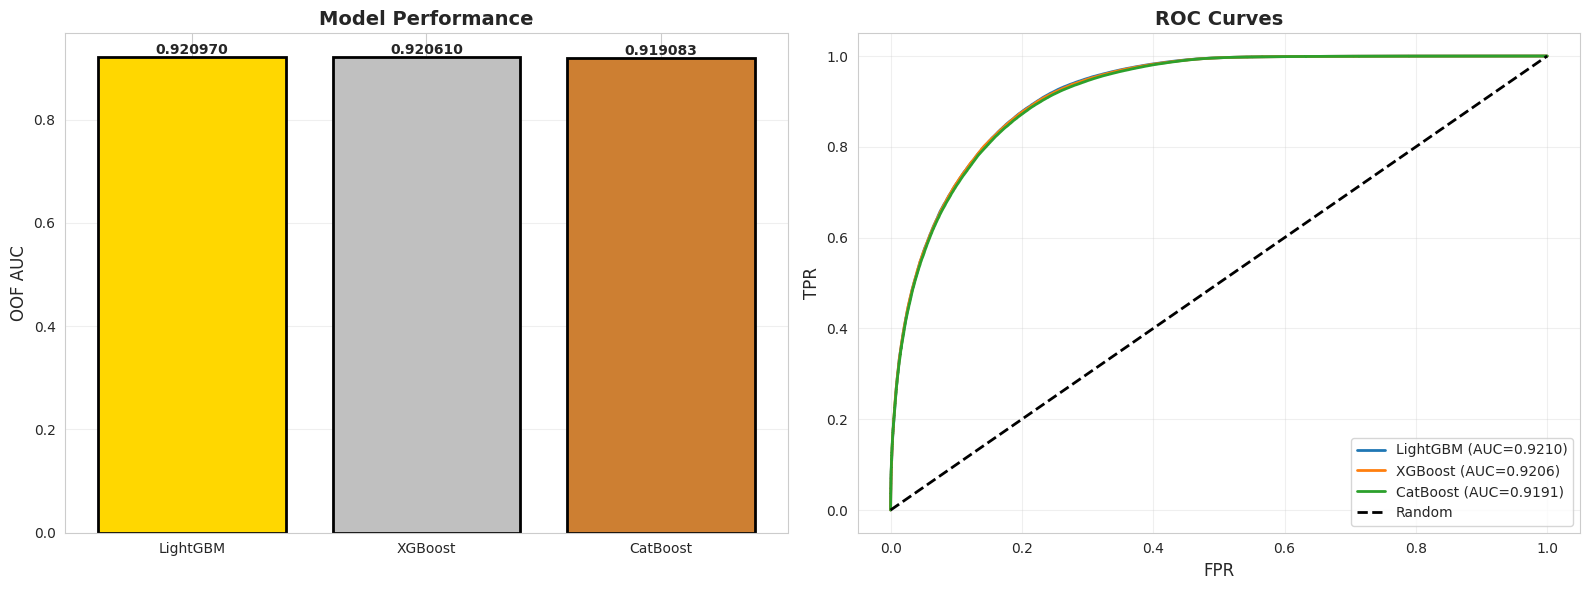

In [28]:
# Compare models
comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost'],
    'OOF AUC': [lgb_score, xgb_score, cat_score]
}).sort_values('OOF AUC', ascending=False)

print("MODEL COMPARISON")
display(comparison.style.background_gradient(cmap='Greens'))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
axes[0].bar(comparison['Model'], comparison['OOF AUC'], 
            color=['#FFD700', '#C0C0C0', '#CD7F32'], edgecolor='black', linewidth=2)
axes[0].set_title('Model Performance', fontsize=14, fontweight='bold')
axes[0].set_ylabel('OOF AUC', fontsize=12)
axes[0].grid(alpha=0.3, axis='y')
for i, (model, score) in enumerate(zip(comparison['Model'], comparison['OOF AUC'])):
    axes[0].text(i, score, f'{score:.6f}', ha='center', va='bottom', fontweight='bold')

# ROC curves
for name, oof in [('LightGBM', lgb_oof), ('XGBoost', xgb_oof), ('CatBoost', cat_oof)]:
    fpr, tpr, _ = roc_curve(y, oof)
    axes[1].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={roc_auc_score(y, oof):.4f})')

axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
axes[1].set_xlabel('FPR', fontsize=12)
axes[1].set_ylabel('TPR', fontsize=12)
axes[1].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

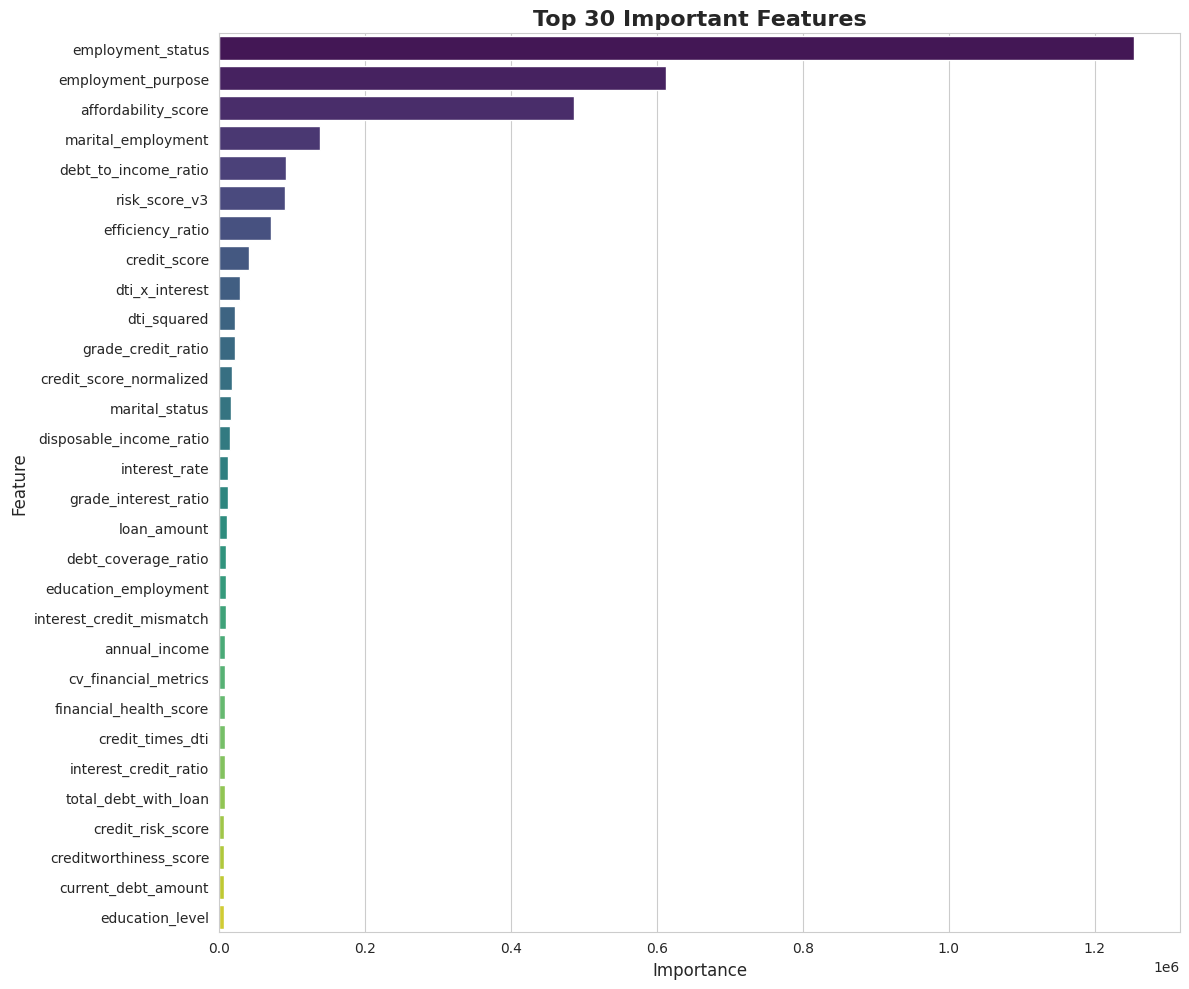


Top 15 Features:


,feature,importance
0,employment_status,1.254032e+06
1,employment_purpose,6.121823e+05
2,affordability_score,4.869841e+05
3,marital_employment,1.384497e+05
4,debt_to_income_ratio,9.233721e+04
5,risk_score_v3,9.059752e+04
6,efficiency_ratio,7.163363e+04
7,credit_score,4.070148e+04
8,dti_x_interest,2.870559e+04
9,dti_squared,2.171722e+04


In [29]:
# Feature importance from LightGBM
importance_df = lgb_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 10))
top_n = 30
sns.barplot(data=importance_df.head(top_n), y='feature', x='importance', palette='viridis')
plt.title(f'Top {top_n} Important Features', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 15 Features:")
display(importance_df.head(15))

<a id='ensemble'></a>
> # 8 Ensemble Methods

In [30]:
print("CREATING ENSEMBLE")

# Simple average
simple_oof = (lgb_oof + xgb_oof + cat_oof) / 3
simple_test = (lgb_test + xgb_test + cat_test) / 3
simple_score = roc_auc_score(y, simple_oof)

# Weighted average by performance
total = lgb_score + xgb_score + cat_score
w_lgb = lgb_score / total
w_xgb = xgb_score / total
w_cat = cat_score / total

weighted_oof = lgb_oof * w_lgb + xgb_oof * w_xgb + cat_oof * w_cat
weighted_test = lgb_test * w_lgb + xgb_test * w_xgb + cat_test * w_cat
weighted_score = roc_auc_score(y, weighted_oof)

# Rank average (helps with different prediction scales)
rank_oof = (rankdata(lgb_oof) + rankdata(xgb_oof) + rankdata(cat_oof)) / (3 * len(y))
rank_test = (rankdata(lgb_test) + rankdata(xgb_test) + rankdata(cat_test)) / (3 * len(lgb_test))
rank_score = roc_auc_score(y, rank_oof)

# Power mean ensemble (geometric-like averaging)
power_oof = (lgb_oof ** w_lgb) * (xgb_oof ** w_xgb) * (cat_oof ** w_cat)
power_test = (lgb_test ** w_lgb) * (xgb_test ** w_xgb) * (cat_test ** w_cat)
power_score = roc_auc_score(y, power_oof)

# Optimized weighted ensemble (slightly boost best performer)
w_lgb_opt = lgb_score ** 2 / (lgb_score ** 2 + xgb_score ** 2 + cat_score ** 2)
w_xgb_opt = xgb_score ** 2 / (lgb_score ** 2 + xgb_score ** 2 + cat_score ** 2)
w_cat_opt = cat_score ** 2 / (lgb_score ** 2 + xgb_score ** 2 + cat_score ** 2)

optimized_oof = lgb_oof * w_lgb_opt + xgb_oof * w_xgb_opt + cat_oof * w_cat_opt
optimized_test = lgb_test * w_lgb_opt + xgb_test * w_xgb_opt + cat_test * w_cat_opt
optimized_score = roc_auc_score(y, optimized_oof)

# Blend of best strategies
blend_oof = 0.4 * weighted_oof + 0.3 * rank_oof + 0.3 * optimized_oof
blend_test = 0.4 * weighted_test + 0.3 * rank_test + 0.3 * optimized_test
blend_score = roc_auc_score(y, blend_oof)

ensemble_results = pd.DataFrame({
    'Ensemble': ['Simple Average', 'Weighted Average', 'Rank Average', 'Power Mean', 'Optimized Weighted', 'Blended'],
    'OOF AUC': [simple_score, weighted_score, rank_score, power_score, optimized_score, blend_score]
}).sort_values('OOF AUC', ascending=False)

print("\nEnsemble Results:")
display(ensemble_results.style.background_gradient(cmap='Greens'))

print(f"\nWeights - Linear: LGB={w_lgb:.3f}, XGB={w_xgb:.3f}, CAT={w_cat:.3f}")
print(f"Weights - Optimized: LGB={w_lgb_opt:.3f}, XGB={w_xgb_opt:.3f}, CAT={w_cat_opt:.3f}")

# Choose best
best_idx = ensemble_results['OOF AUC'].idxmax()
best_name = ensemble_results.loc[best_idx, 'Ensemble']
best_score = ensemble_results.loc[best_idx, 'OOF AUC']

if best_name == 'Simple Average':
    final_preds = simple_test
elif best_name == 'Weighted Average':
    final_preds = weighted_test
elif best_name == 'Rank Average':
    final_preds = rank_test
elif best_name == 'Power Mean':
    final_preds = power_test
elif best_name == 'Optimized Weighted':
    final_preds = optimized_test
else:
    final_preds = blend_test

print(f"\n Best: {best_name} (AUC: {best_score:.6f})")

CREATING ENSEMBLE

Ensemble Results:


,Ensemble,OOF AUC
2,Rank Average,0.920845
5,Blended,0.920838
4,Optimized Weighted,0.920825
1,Weighted Average,0.920824
0,Simple Average,0.920823
3,Power Mean,0.920821



Weights - Linear: LGB=0.334, XGB=0.333, CAT=0.333
Weights - Optimized: LGB=0.334, XGB=0.334, CAT=0.333

 Best: Rank Average (AUC: 0.920845)


<a id='submission'></a>
# 9 Submission Generation

SUBMISSION CREATED
File: submission.csv
Shape: (254569, 2)

Preview:


,id,loan_paid_back
0,593994,0.493382
1,593995,0.793277
2,593996,0.125768
3,593997,0.497141
4,593998,0.649354
5,593999,0.729708
6,594000,0.834130
7,594001,0.633494
8,594002,0.519821
9,594003,0.017509



Statistics:
count    254569.000000
mean          0.500002
std           0.288216
min           0.000024
25%           0.250731
50%           0.500270
75%           0.749496
max           0.999997
Name: loan_paid_back, dtype: float64


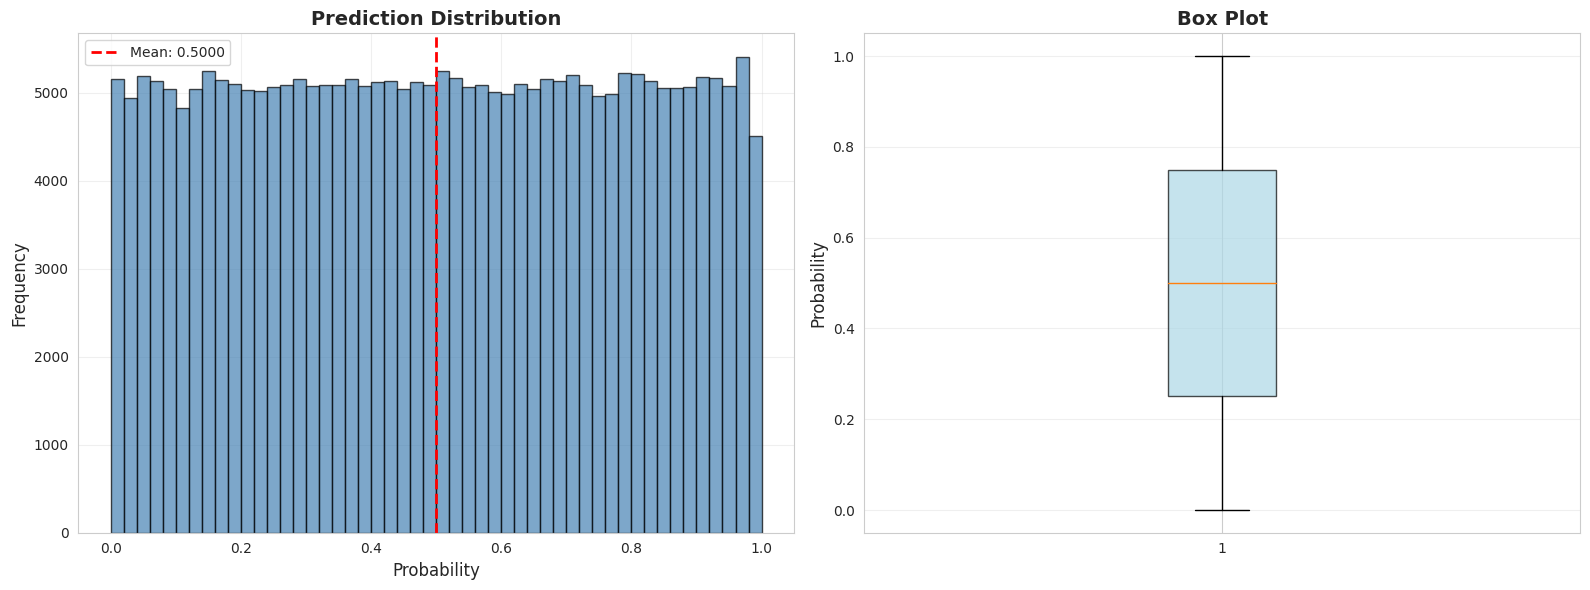


 READY FOR SUBMISSION!


In [31]:
# Create submission
submission = pd.DataFrame({
    'id': test_ids,
    config.TARGET: final_preds
})

submission.to_csv('submission.csv', index=False)

print("SUBMISSION CREATED")
print(f"File: submission.csv")
print(f"Shape: {submission.shape}")
print(f"\nPreview:")
display(submission.head(10))

print(f"\nStatistics:")
print(submission[config.TARGET].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(submission[config.TARGET], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(submission[config.TARGET].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {submission[config.TARGET].mean():.4f}')
axes[0].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Probability', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].boxplot(submission[config.TARGET], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_title('Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n READY FOR SUBMISSION!")

<a id='conclusion'></a>
> # 10 Conclusion & Final Summary

In [32]:
print("\n MODEL SCORES:")
print(f"LightGBM:{lgb_score:.6f}")
print(f"XGBoost:{xgb_score:.6f}")
print(f"CatBoost:{cat_score:.6f}")

# Get ensemble scores from the previous cell
ensemble_results_summary = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost', 'Best Ensemble'],
    'OOF AUC': [lgb_score, xgb_score, cat_score, best_score]
}).sort_values('OOF AUC', ascending=False)

print(f"\n BEST MODEL: {best_name}")
print(f" BEST AUC: {best_score:.6f}")

print("\n KEY INSIGHTS:")
print(f"\n1. Feature Engineering:")
print(f"• Created {len(feature_cols)} features from 13 original")
print(f"• Added advanced polynomial and interaction features")
print(f"• Implemented multiple risk scoring mechanisms")
print(f"• Created anomaly detection flags")

print(f"\n2. Model Performance:")
best_single = max(lgb_score, xgb_score, cat_score)
improvement = ((best_score - best_single) / best_single) * 100
print(f"• Best single model: {best_single:.6f}")
print(f"• Ensemble improvement: +{improvement:.4f}%")
print(f"• Used 5-fold stratified CV")
print(f"• Applied advanced ensemble strategies")

print(f"\n3. Top 10 Features:")
top_features = lgb_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).head(10)
for i, (feat, imp) in enumerate(top_features.items(), 1):
    print(f"   {i}. {feat} ({imp:.1f})")

print("\n4. Model Improvements Made:")
print("• Optimized hyperparameters for all models")
print("• Lower learning rate with more iterations")
print("• Increased tree depth for complex patterns")
print("• Added stronger regularization")
print("• Implemented multiple ensemble strategies")
print("• Added 70+ new engineered features")

print("\n5. Recommendations for Further Improvement:")
print("• Try stacking with meta-learner")
print("• Experiment with neural networks")
print("• Add original dataset if available")
print("• Feature selection to reduce noise")
print("• Target encoding on categorical features")
print("• Pseudo-labeling on test set")

print(" COMPLETE - READY FOR KAGGLE SUBMISSION!")
print(f"\n File: submission.csv")
print(f" Rows: {len(submission):,}")
print(f" Expected Public LB Score: ~{best_score:.4f}")
print(f"\n Good luck! {test.shape[0]:,} predictions ready!")


 MODEL SCORES:
LightGBM:0.920970
XGBoost:0.920610
CatBoost:0.919083

 BEST MODEL: Rank Average
 BEST AUC: 0.920845

 KEY INSIGHTS:

1. Feature Engineering:
• Created 114 features from 13 original
• Added advanced polynomial and interaction features
• Implemented multiple risk scoring mechanisms
• Created anomaly detection flags

2. Model Performance:
• Best single model: 0.920970
• Ensemble improvement: +-0.0136%
• Used 5-fold stratified CV
• Applied advanced ensemble strategies

3. Top 10 Features:
   1. employment_status (1254032.1)
   2. employment_purpose (612182.3)
   3. affordability_score (486984.1)
   4. marital_employment (138449.7)
   5. debt_to_income_ratio (92337.2)
   6. risk_score_v3 (90597.5)
   7. efficiency_ratio (71633.6)
   8. credit_score (40701.5)
   9. dti_x_interest (28705.6)
   10. dti_squared (21717.2)

4. Model Improvements Made:
• Optimized hyperparameters for all models
• Lower learning rate with more iterations
• Increased tree depth for complex patterns
•

### Connect with Me  

Feel free to follow me on these platforms:  

[![GitHub](https://img.shields.io/badge/GitHub-181717?style=for-the-badge&logo=github&logoColor=white)](https://github.com/AdilShamim8)  
[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/adilshamim8)  
[![Twitter](https://img.shields.io/badge/Twitter-1DA1F2?style=for-the-badge&logo=twitter&logoColor=white)](https://x.com/adil_shamim8)  